# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.466779698324851 -2.606996774785296
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [103]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [104]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [121]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [122]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [123]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [124]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [125]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [126]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [127]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.0711 dloss:1.3189 dlossR:0.6275 dlossQ:0.6914
Episode:1 meanR:25.0000 rate:0.0820 gloss:0.0057 dloss:1.3558 dlossR:0.6633 dlossQ:0.6926
Episode:2 meanR:27.6667 rate:0.0660 gloss:-0.0509 dloss:1.3274 dlossR:0.6370 dlossQ:0.6904
Episode:3 meanR:37.7500 rate:0.1360 gloss:0.0023 dloss:1.3430 dlossR:0.6487 dlossQ:0.6943
Episode:4 meanR:44.4000 rate:0.1420 gloss:-0.0327 dloss:1.3255 dlossR:0.6319 dlossQ:0.6936
Episode:5 meanR:43.0000 rate:0.0720 gloss:-0.0253 dloss:1.3406 dlossR:0.6469 dlossQ:0.6937
Episode:6 meanR:41.7143 rate:0.0680 gloss:-0.0431 dloss:1.3303 dlossR:0.6370 dlossQ:0.6933
Episode:7 meanR:41.1250 rate:0.0740 gloss:-0.0549 dloss:1.3216 dlossR:0.6285 dlossQ:0.6931
Episode:8 meanR:39.2222 rate:0.0480 gloss:-0.0966 dloss:1.2993 dlossR:0.6083 dlossQ:0.6910
Episode:9 meanR:37.6000 rate:0.0460 gloss:-0.1219 dloss:1.2825 dlossR:0.5929 dlossQ:0.6896
Episode:10 meanR:36.5455 rate:0.0520 gloss:-0.1443 dloss:1.2672 dlossR:0.5792 dlossQ:0.6880
E

Episode:95 meanR:33.4167 rate:0.2080 gloss:-1.4853 dloss:0.9783 dlossR:0.6018 dlossQ:0.3765
Episode:96 meanR:33.5258 rate:0.0880 gloss:-1.2752 dloss:0.7141 dlossR:0.3037 dlossQ:0.4104
Episode:97 meanR:33.7959 rate:0.1200 gloss:-1.2419 dloss:0.7862 dlossR:0.3675 dlossQ:0.4186
Episode:98 meanR:34.4343 rate:0.1940 gloss:-1.1200 dloss:0.9592 dlossR:0.5052 dlossQ:0.4540
Episode:99 meanR:34.6500 rate:0.1120 gloss:-1.2246 dloss:0.7766 dlossR:0.3523 dlossQ:0.4243
Episode:100 meanR:35.0500 rate:0.0980 gloss:-1.2469 dloss:0.7407 dlossR:0.3245 dlossQ:0.4162
Episode:101 meanR:35.0400 rate:0.0800 gloss:-1.2582 dloss:0.7044 dlossR:0.2892 dlossQ:0.4152
Episode:102 meanR:35.1600 rate:0.0900 gloss:-1.1519 dloss:0.7591 dlossR:0.3143 dlossQ:0.4448
Episode:103 meanR:35.0900 rate:0.1220 gloss:-1.2092 dloss:0.7990 dlossR:0.3717 dlossQ:0.4273
Episode:104 meanR:34.7600 rate:0.0760 gloss:-1.2485 dloss:0.7015 dlossR:0.2824 dlossQ:0.4191
Episode:105 meanR:34.7800 rate:0.0760 gloss:-1.2561 dloss:0.6988 dlossR:0.2

Episode:186 meanR:34.0600 rate:0.0260 gloss:-1.1613 dloss:0.6501 dlossR:0.1936 dlossQ:0.4565
Episode:187 meanR:34.1100 rate:0.0280 gloss:-1.2108 dloss:0.6331 dlossR:0.1909 dlossQ:0.4422
Episode:188 meanR:34.1500 rate:0.0280 gloss:-1.2361 dloss:0.6208 dlossR:0.1870 dlossQ:0.4338
Episode:189 meanR:34.1300 rate:0.0180 gloss:-1.2072 dloss:0.6303 dlossR:0.1659 dlossQ:0.4644
Episode:190 meanR:34.1500 rate:0.0280 gloss:-1.2847 dloss:0.6115 dlossR:0.1810 dlossQ:0.4305
Episode:191 meanR:34.1700 rate:0.0220 gloss:-1.2720 dloss:0.6069 dlossR:0.1678 dlossQ:0.4390
Episode:192 meanR:34.0200 rate:0.0200 gloss:-1.2840 dloss:0.6099 dlossR:0.1615 dlossQ:0.4484
Episode:193 meanR:34.0700 rate:0.0560 gloss:-1.2346 dloss:0.6727 dlossR:0.2458 dlossQ:0.4269
Episode:194 meanR:33.9700 rate:0.0880 gloss:-1.3438 dloss:0.7035 dlossR:0.3051 dlossQ:0.3984
Episode:195 meanR:33.5100 rate:0.1160 gloss:-1.3019 dloss:0.7620 dlossR:0.3617 dlossQ:0.4003
Episode:196 meanR:33.6300 rate:0.1120 gloss:-1.3567 dloss:0.7369 dloss

Episode:280 meanR:36.0100 rate:0.0560 gloss:-1.4913 dloss:0.5756 dlossR:0.2239 dlossQ:0.3518
Episode:281 meanR:35.5500 rate:0.0480 gloss:-1.5022 dloss:0.5562 dlossR:0.2044 dlossQ:0.3518
Episode:282 meanR:35.7700 rate:0.1380 gloss:-1.4972 dloss:0.7560 dlossR:0.4158 dlossQ:0.3403
Episode:283 meanR:35.5700 rate:0.0580 gloss:-1.5129 dloss:0.5732 dlossR:0.2275 dlossQ:0.3457
Episode:284 meanR:35.3500 rate:0.0660 gloss:-1.5112 dloss:0.5902 dlossR:0.2464 dlossQ:0.3438
Episode:285 meanR:34.8900 rate:0.0180 gloss:-1.4399 dloss:0.5479 dlossR:0.1309 dlossQ:0.4170
Episode:286 meanR:35.0500 rate:0.0580 gloss:-1.5102 dloss:0.5736 dlossR:0.2276 dlossQ:0.3459
Episode:287 meanR:35.2400 rate:0.0660 gloss:-1.5199 dloss:0.5863 dlossR:0.2461 dlossQ:0.3402
Episode:288 meanR:35.4500 rate:0.0700 gloss:-1.5098 dloss:0.5977 dlossR:0.2559 dlossQ:0.3418
Episode:289 meanR:35.5500 rate:0.0380 gloss:-1.6222 dloss:0.5128 dlossR:0.1739 dlossQ:0.3389
Episode:290 meanR:35.8800 rate:0.0940 gloss:-1.5266 dloss:0.6462 dloss

Episode:371 meanR:29.0700 rate:0.1320 gloss:-1.7677 dloss:0.6976 dlossR:0.4254 dlossQ:0.2722
Episode:372 meanR:29.1300 rate:0.0460 gloss:-1.7489 dloss:0.4823 dlossR:0.1892 dlossQ:0.2931
Episode:373 meanR:29.2600 rate:0.0520 gloss:-1.9132 dloss:0.4633 dlossR:0.2045 dlossQ:0.2588
Episode:374 meanR:29.2800 rate:0.0380 gloss:-1.9380 dloss:0.4312 dlossR:0.1626 dlossQ:0.2687
Episode:375 meanR:29.2800 rate:0.0320 gloss:-1.9316 dloss:0.4271 dlossR:0.1443 dlossQ:0.2828
Episode:376 meanR:29.3900 rate:0.0520 gloss:-1.9660 dloss:0.4571 dlossR:0.2049 dlossQ:0.2522
Episode:377 meanR:29.3200 rate:0.0220 gloss:-2.0211 dloss:0.4258 dlossR:0.1109 dlossQ:0.3150
Episode:378 meanR:29.3000 rate:0.0280 gloss:-1.9934 dloss:0.4224 dlossR:0.1312 dlossQ:0.2912
Episode:379 meanR:29.2400 rate:0.0260 gloss:-1.9174 dloss:0.4337 dlossR:0.1264 dlossQ:0.3074
Episode:380 meanR:29.2100 rate:0.0500 gloss:-1.8869 dloss:0.4650 dlossR:0.1986 dlossQ:0.2664
Episode:381 meanR:29.0600 rate:0.0180 gloss:-1.6534 dloss:0.4835 dloss

Episode:462 meanR:30.9000 rate:0.0260 gloss:-1.5202 dloss:0.5190 dlossR:0.1496 dlossQ:0.3694
Episode:463 meanR:30.8800 rate:0.0200 gloss:-0.8313 dloss:0.7917 dlossR:0.2522 dlossQ:0.5395
Episode:464 meanR:30.9400 rate:0.0360 gloss:-1.6143 dloss:0.5064 dlossR:0.1691 dlossQ:0.3373
Episode:465 meanR:30.9700 rate:0.0320 gloss:-1.6606 dloss:0.4883 dlossR:0.1559 dlossQ:0.3324
Episode:466 meanR:30.9600 rate:0.0200 gloss:-0.9474 dloss:0.7297 dlossR:0.2206 dlossQ:0.5092
Episode:467 meanR:30.8600 rate:0.0180 gloss:-0.9665 dloss:0.7164 dlossR:0.2088 dlossQ:0.5076
Episode:468 meanR:30.7700 rate:0.0200 gloss:-1.6716 dloss:0.4818 dlossR:0.1208 dlossQ:0.3610
Episode:469 meanR:30.6000 rate:0.0320 gloss:-1.7707 dloss:0.4605 dlossR:0.1506 dlossQ:0.3100
Episode:470 meanR:30.5500 rate:0.0280 gloss:-1.7976 dloss:0.4546 dlossR:0.1379 dlossQ:0.3167
Episode:471 meanR:30.0200 rate:0.0260 gloss:-1.7953 dloss:0.4520 dlossR:0.1318 dlossQ:0.3203
Episode:472 meanR:30.0800 rate:0.0580 gloss:-1.4950 dloss:0.5774 dloss

Episode:554 meanR:25.2900 rate:0.3220 gloss:-1.5497 dloss:1.2348 dlossR:0.9090 dlossQ:0.3258
Episode:555 meanR:25.8500 rate:0.1500 gloss:-1.5440 dloss:0.7779 dlossR:0.4506 dlossQ:0.3273
Episode:556 meanR:25.8100 rate:0.0200 gloss:-1.4300 dloss:0.5313 dlossR:0.1386 dlossQ:0.3927
Episode:557 meanR:25.9100 rate:0.0460 gloss:-1.5519 dloss:0.5320 dlossR:0.1973 dlossQ:0.3347
Episode:558 meanR:25.9100 rate:0.0360 gloss:-1.4804 dloss:0.5394 dlossR:0.1778 dlossQ:0.3616
Episode:559 meanR:25.9300 rate:0.0300 gloss:-1.3882 dloss:0.5575 dlossR:0.1721 dlossQ:0.3854
Episode:560 meanR:25.8400 rate:0.0200 gloss:-1.2299 dloss:0.6108 dlossR:0.1645 dlossQ:0.4463
Episode:561 meanR:26.0300 rate:0.0620 gloss:-1.4803 dloss:0.5877 dlossR:0.2391 dlossQ:0.3486
Episode:562 meanR:26.1500 rate:0.0500 gloss:-1.4325 dloss:0.5785 dlossR:0.2148 dlossQ:0.3638
Episode:563 meanR:26.2900 rate:0.0480 gloss:-1.3979 dloss:0.5856 dlossR:0.2138 dlossQ:0.3718
Episode:564 meanR:26.5700 rate:0.0920 gloss:-1.4315 dloss:0.6675 dloss

Episode:645 meanR:34.2400 rate:0.0720 gloss:-1.2492 dloss:0.6876 dlossR:0.2742 dlossQ:0.4135
Episode:646 meanR:34.2500 rate:0.0280 gloss:-1.0554 dloss:0.6948 dlossR:0.2178 dlossQ:0.4770
Episode:647 meanR:34.7700 rate:0.1260 gloss:-1.1837 dloss:0.8113 dlossR:0.3794 dlossQ:0.4319
Episode:648 meanR:34.8500 rate:0.0860 gloss:-1.1790 dloss:0.7408 dlossR:0.3058 dlossQ:0.4350
Episode:649 meanR:36.2000 rate:0.3460 gloss:-1.0204 dloss:1.2768 dlossR:0.7853 dlossQ:0.4915
Episode:650 meanR:36.2100 rate:0.1840 gloss:-0.6263 dloss:1.1044 dlossR:0.5291 dlossQ:0.5753
Episode:651 meanR:36.8300 rate:0.1600 gloss:-0.5481 dloss:1.1094 dlossR:0.5129 dlossQ:0.5965
Episode:652 meanR:36.8900 rate:0.0560 gloss:-0.9067 dloss:0.8144 dlossR:0.2986 dlossQ:0.5157
Episode:653 meanR:36.6000 rate:0.0260 gloss:-0.8336 dloss:0.8077 dlossR:0.2690 dlossQ:0.5387
Episode:654 meanR:35.1400 rate:0.0300 gloss:-0.9040 dloss:0.7765 dlossR:0.2594 dlossQ:0.5172
Episode:655 meanR:34.7200 rate:0.0660 gloss:-0.9862 dloss:0.7905 dloss

Episode:739 meanR:38.7300 rate:0.0760 gloss:-1.4847 dloss:0.6173 dlossR:0.2710 dlossQ:0.3463
Episode:740 meanR:38.8600 rate:0.1760 gloss:-1.3411 dloss:0.8791 dlossR:0.4946 dlossQ:0.3845
Episode:741 meanR:38.9900 rate:0.1160 gloss:-1.4954 dloss:0.7041 dlossR:0.3638 dlossQ:0.3403
Episode:742 meanR:39.6700 rate:0.1640 gloss:-1.4318 dloss:0.8295 dlossR:0.4722 dlossQ:0.3573
Episode:743 meanR:40.0400 rate:0.1340 gloss:-1.4183 dloss:0.7636 dlossR:0.4021 dlossQ:0.3614
Episode:744 meanR:40.1700 rate:0.0940 gloss:-1.3142 dloss:0.7083 dlossR:0.3154 dlossQ:0.3930
Episode:745 meanR:39.9800 rate:0.0340 gloss:-1.4564 dloss:0.5436 dlossR:0.1746 dlossQ:0.3690
Episode:746 meanR:40.0000 rate:0.0320 gloss:-1.5027 dloss:0.5256 dlossR:0.1656 dlossQ:0.3600
Episode:747 meanR:39.5300 rate:0.0320 gloss:-1.4610 dloss:0.5385 dlossR:0.1692 dlossQ:0.3693
Episode:748 meanR:39.2300 rate:0.0260 gloss:-1.4428 dloss:0.5354 dlossR:0.1554 dlossQ:0.3800
Episode:749 meanR:37.6300 rate:0.0260 gloss:-1.4119 dloss:0.5481 dloss

Episode:829 meanR:26.1700 rate:0.0920 gloss:-1.5939 dloss:0.6256 dlossR:0.3107 dlossQ:0.3149
Episode:830 meanR:26.6600 rate:0.1260 gloss:-1.7012 dloss:0.6870 dlossR:0.4032 dlossQ:0.2839
Episode:831 meanR:26.9100 rate:0.0720 gloss:-1.6561 dloss:0.5623 dlossR:0.2603 dlossQ:0.3021
Episode:832 meanR:26.8700 rate:0.0240 gloss:-1.7168 dloss:0.4539 dlossR:0.1284 dlossQ:0.3255
Episode:833 meanR:26.9500 rate:0.0920 gloss:-1.6738 dloss:0.6067 dlossR:0.3118 dlossQ:0.2949
Episode:834 meanR:27.2500 rate:0.0780 gloss:-1.6231 dloss:0.5849 dlossR:0.2755 dlossQ:0.3094
Episode:835 meanR:27.4000 rate:0.0860 gloss:-1.6021 dloss:0.6091 dlossR:0.2956 dlossQ:0.3135
Episode:836 meanR:27.1400 rate:0.0380 gloss:-1.5646 dloss:0.5110 dlossR:0.1810 dlossQ:0.3300
Episode:837 meanR:26.8500 rate:0.0260 gloss:-1.6440 dloss:0.4757 dlossR:0.1389 dlossQ:0.3367
Episode:838 meanR:26.7500 rate:0.0760 gloss:-1.5930 dloss:0.5874 dlossR:0.2705 dlossQ:0.3170
Episode:839 meanR:26.5700 rate:0.0400 gloss:-1.5541 dloss:0.5183 dloss

Episode:922 meanR:27.2400 rate:0.0240 gloss:-1.5023 dloss:0.5051 dlossR:0.1459 dlossQ:0.3592
Episode:923 meanR:27.1900 rate:0.0200 gloss:-1.3270 dloss:0.5617 dlossR:0.1545 dlossQ:0.4072
Episode:924 meanR:28.5800 rate:0.2960 gloss:-1.4895 dloss:1.1577 dlossR:0.8169 dlossQ:0.3409
Episode:925 meanR:28.4600 rate:0.0180 gloss:-1.2575 dloss:0.5841 dlossR:0.1606 dlossQ:0.4235
Episode:926 meanR:28.4200 rate:0.0460 gloss:-1.4347 dloss:0.5691 dlossR:0.2104 dlossQ:0.3588
Episode:927 meanR:28.5600 rate:0.1260 gloss:-1.3094 dloss:0.7822 dlossR:0.3898 dlossQ:0.3924
Episode:928 meanR:28.5300 rate:0.0660 gloss:-1.3792 dloss:0.6312 dlossR:0.2566 dlossQ:0.3746
Episode:929 meanR:28.1600 rate:0.0180 gloss:-1.1349 dloss:0.6376 dlossR:0.1805 dlossQ:0.4571
Episode:930 meanR:27.7800 rate:0.0500 gloss:-1.2493 dloss:0.6474 dlossR:0.2346 dlossQ:0.4128
Episode:931 meanR:27.8700 rate:0.0900 gloss:-1.4077 dloss:0.6718 dlossR:0.3062 dlossQ:0.3657
Episode:932 meanR:28.1800 rate:0.0860 gloss:-1.2552 dloss:0.7167 dloss

Episode:1010 meanR:34.8000 rate:0.0380 gloss:-1.6805 dloss:0.4817 dlossR:0.1703 dlossQ:0.3114
Episode:1011 meanR:34.8300 rate:0.0300 gloss:-1.5970 dloss:0.4893 dlossR:0.1537 dlossQ:0.3356
Episode:1012 meanR:34.9700 rate:0.0500 gloss:-1.6650 dloss:0.5098 dlossR:0.2028 dlossQ:0.3070
Episode:1013 meanR:35.0000 rate:0.0380 gloss:-1.6058 dloss:0.5019 dlossR:0.1744 dlossQ:0.3276
Episode:1014 meanR:35.1100 rate:0.0720 gloss:-1.6499 dloss:0.5623 dlossR:0.2595 dlossQ:0.3027
Episode:1015 meanR:35.0600 rate:0.0520 gloss:-1.5900 dloss:0.5330 dlossR:0.2112 dlossQ:0.3218
Episode:1016 meanR:34.6100 rate:0.1380 gloss:-1.6037 dloss:0.7351 dlossR:0.4259 dlossQ:0.3093
Episode:1017 meanR:34.3300 rate:0.1000 gloss:-1.5128 dloss:0.6638 dlossR:0.3285 dlossQ:0.3353
Episode:1018 meanR:34.2300 rate:0.1160 gloss:-1.5367 dloss:0.6963 dlossR:0.3679 dlossQ:0.3284
Episode:1019 meanR:34.3100 rate:0.0900 gloss:-1.5291 dloss:0.6376 dlossR:0.3056 dlossQ:0.3321
Episode:1020 meanR:34.2200 rate:0.0700 gloss:-1.5232 dloss:0

Episode:1103 meanR:32.0500 rate:0.1000 gloss:-1.1745 dloss:0.7692 dlossR:0.3353 dlossQ:0.4339
Episode:1104 meanR:33.3000 rate:0.2860 gloss:-1.0957 dloss:1.1497 dlossR:0.6872 dlossQ:0.4625
Episode:1105 meanR:33.5400 rate:0.0880 gloss:-1.0317 dloss:0.8073 dlossR:0.3292 dlossQ:0.4781
Episode:1106 meanR:33.8000 rate:0.0980 gloss:-1.0889 dloss:0.8008 dlossR:0.3408 dlossQ:0.4599
Episode:1107 meanR:34.1100 rate:0.0860 gloss:-1.0878 dloss:0.7823 dlossR:0.3223 dlossQ:0.4600
Episode:1108 meanR:34.3800 rate:0.0820 gloss:-1.1450 dloss:0.7508 dlossR:0.3085 dlossQ:0.4423
Episode:1109 meanR:34.5800 rate:0.0700 gloss:-1.1306 dloss:0.7367 dlossR:0.2892 dlossQ:0.4476
Episode:1110 meanR:34.5700 rate:0.0360 gloss:-1.2615 dloss:0.6165 dlossR:0.2028 dlossQ:0.4137
Episode:1111 meanR:34.6400 rate:0.0440 gloss:-1.3077 dloss:0.6126 dlossR:0.2141 dlossQ:0.3984
Episode:1112 meanR:34.5400 rate:0.0300 gloss:-1.3740 dloss:0.5625 dlossR:0.1742 dlossQ:0.3883
Episode:1113 meanR:34.4700 rate:0.0240 gloss:-1.3289 dloss:0

Episode:1198 meanR:35.8800 rate:0.0240 gloss:-1.5505 dloss:0.4924 dlossR:0.1429 dlossQ:0.3495
Episode:1199 meanR:35.5600 rate:0.0460 gloss:-1.6646 dloss:0.5001 dlossR:0.1928 dlossQ:0.3072
Episode:1200 meanR:35.6000 rate:0.0300 gloss:-1.5289 dloss:0.5100 dlossR:0.1593 dlossQ:0.3507
Episode:1201 meanR:35.6100 rate:0.0260 gloss:-1.5763 dloss:0.4912 dlossR:0.1450 dlossQ:0.3461
Episode:1202 meanR:35.9900 rate:0.1620 gloss:-1.1454 dloss:0.9087 dlossR:0.4645 dlossQ:0.4442
Episode:1203 meanR:35.7000 rate:0.0420 gloss:-1.4806 dloss:0.5493 dlossR:0.1945 dlossQ:0.3548
Episode:1204 meanR:34.4200 rate:0.0300 gloss:-1.6294 dloss:0.4794 dlossR:0.1526 dlossQ:0.3268
Episode:1205 meanR:34.1300 rate:0.0300 gloss:-1.6434 dloss:0.4757 dlossR:0.1521 dlossQ:0.3236
Episode:1206 meanR:33.7400 rate:0.0200 gloss:-1.5228 dloss:0.4972 dlossR:0.1323 dlossQ:0.3650
Episode:1207 meanR:33.5200 rate:0.0420 gloss:-1.5124 dloss:0.5369 dlossR:0.1914 dlossQ:0.3455
Episode:1208 meanR:33.4700 rate:0.0720 gloss:-1.3653 dloss:0

Episode:1291 meanR:29.3900 rate:0.0340 gloss:-1.5128 dloss:0.5200 dlossR:0.1722 dlossQ:0.3478
Episode:1292 meanR:29.4800 rate:0.0400 gloss:-1.5580 dloss:0.5185 dlossR:0.1828 dlossQ:0.3357
Episode:1293 meanR:29.3100 rate:0.0340 gloss:-1.4971 dloss:0.5248 dlossR:0.1737 dlossQ:0.3512
Episode:1294 meanR:29.2100 rate:0.0920 gloss:-1.5641 dloss:0.6306 dlossR:0.3099 dlossQ:0.3207
Episode:1295 meanR:29.7600 rate:0.1740 gloss:-1.5064 dloss:0.8424 dlossR:0.5064 dlossQ:0.3360
Episode:1296 meanR:30.2000 rate:0.1220 gloss:-1.5421 dloss:0.7077 dlossR:0.3812 dlossQ:0.3266
Episode:1297 meanR:30.1600 rate:0.0520 gloss:-1.5258 dloss:0.5543 dlossR:0.2149 dlossQ:0.3394
Episode:1298 meanR:30.2500 rate:0.0420 gloss:-1.5279 dloss:0.5332 dlossR:0.1902 dlossQ:0.3430
Episode:1299 meanR:30.2300 rate:0.0420 gloss:-1.5321 dloss:0.5329 dlossR:0.1898 dlossQ:0.3432
Episode:1300 meanR:30.2700 rate:0.0380 gloss:-1.5793 dloss:0.5068 dlossR:0.1785 dlossQ:0.3283
Episode:1301 meanR:30.4300 rate:0.0580 gloss:-1.5309 dloss:0

Episode:1381 meanR:33.7200 rate:0.0740 gloss:-1.4575 dloss:0.6238 dlossR:0.2738 dlossQ:0.3500
Episode:1382 meanR:32.7400 rate:0.0240 gloss:-1.4468 dloss:0.5268 dlossR:0.1543 dlossQ:0.3724
Episode:1383 meanR:32.3100 rate:0.0240 gloss:-1.4396 dloss:0.5293 dlossR:0.1548 dlossQ:0.3745
Episode:1384 meanR:31.8800 rate:0.0180 gloss:-1.3819 dloss:0.5380 dlossR:0.1459 dlossQ:0.3921
Episode:1385 meanR:32.6500 rate:0.2280 gloss:-1.3153 dloss:1.0010 dlossR:0.6087 dlossQ:0.3923
Episode:1386 meanR:33.6200 rate:0.2680 gloss:-1.1503 dloss:1.1219 dlossR:0.6832 dlossQ:0.4386
Episode:1387 meanR:33.7400 rate:0.0820 gloss:-1.2209 dloss:0.7248 dlossR:0.3064 dlossQ:0.4184
Episode:1388 meanR:33.8900 rate:0.1000 gloss:-1.2697 dloss:0.7423 dlossR:0.3390 dlossQ:0.4033
Episode:1389 meanR:33.9600 rate:0.0580 gloss:-1.2853 dloss:0.6527 dlossR:0.2517 dlossQ:0.4011
Episode:1390 meanR:33.8200 rate:0.0200 gloss:-1.3222 dloss:0.5658 dlossR:0.1564 dlossQ:0.4094
Episode:1391 meanR:33.9300 rate:0.0560 gloss:-1.3088 dloss:0

Episode:1472 meanR:30.7600 rate:0.1100 gloss:-1.6650 dloss:0.6546 dlossR:0.3599 dlossQ:0.2947
Episode:1473 meanR:30.5600 rate:0.0680 gloss:-1.6327 dloss:0.5581 dlossR:0.2536 dlossQ:0.3045
Episode:1474 meanR:30.3000 rate:0.0240 gloss:-1.6378 dloss:0.4653 dlossR:0.1409 dlossQ:0.3244
Episode:1475 meanR:30.1100 rate:0.0260 gloss:-1.6538 dloss:0.4618 dlossR:0.1445 dlossQ:0.3172
Episode:1476 meanR:30.4400 rate:0.0920 gloss:-1.6603 dloss:0.6096 dlossR:0.3149 dlossQ:0.2947
Episode:1477 meanR:30.4700 rate:0.0260 gloss:-1.6070 dloss:0.4805 dlossR:0.1518 dlossQ:0.3287
Episode:1478 meanR:30.4800 rate:0.0260 gloss:-1.5673 dloss:0.4938 dlossR:0.1564 dlossQ:0.3373
Episode:1479 meanR:30.6500 rate:0.1200 gloss:-1.5477 dloss:0.7076 dlossR:0.3819 dlossQ:0.3257
Episode:1480 meanR:29.9500 rate:0.0820 gloss:-1.6316 dloss:0.5931 dlossR:0.2881 dlossQ:0.3050
Episode:1481 meanR:29.8300 rate:0.0500 gloss:-1.6251 dloss:0.5217 dlossR:0.2081 dlossQ:0.3137
Episode:1482 meanR:29.8600 rate:0.0300 gloss:-1.6075 dloss:0

Episode:1562 meanR:42.4200 rate:0.0740 gloss:-1.4789 dloss:0.6166 dlossR:0.2678 dlossQ:0.3488
Episode:1563 meanR:42.3700 rate:0.0460 gloss:-1.5430 dloss:0.5427 dlossR:0.1987 dlossQ:0.3439
Episode:1564 meanR:42.3300 rate:0.0780 gloss:-1.4291 dloss:0.6410 dlossR:0.2786 dlossQ:0.3623
Episode:1565 meanR:43.0400 rate:0.1880 gloss:-1.4340 dloss:0.8874 dlossR:0.5287 dlossQ:0.3588
Episode:1566 meanR:43.7600 rate:0.1840 gloss:-1.3073 dloss:0.8998 dlossR:0.5056 dlossQ:0.3942
Episode:1567 meanR:43.9600 rate:0.0660 gloss:-1.2128 dloss:0.6916 dlossR:0.2686 dlossQ:0.4230
Episode:1568 meanR:44.2400 rate:0.0900 gloss:-1.3108 dloss:0.7037 dlossR:0.3107 dlossQ:0.3930
Episode:1569 meanR:44.4400 rate:0.0680 gloss:-1.3632 dloss:0.6415 dlossR:0.2620 dlossQ:0.3795
Episode:1570 meanR:44.5200 rate:0.0360 gloss:-1.3639 dloss:0.5765 dlossR:0.1910 dlossQ:0.3854
Episode:1571 meanR:44.4600 rate:0.0220 gloss:-1.4034 dloss:0.5407 dlossR:0.1511 dlossQ:0.3895
Episode:1572 meanR:44.0500 rate:0.0280 gloss:-1.4321 dloss:0

Episode:1656 meanR:26.8300 rate:0.0340 gloss:-1.5712 dloss:0.5000 dlossR:0.1696 dlossQ:0.3304
Episode:1657 meanR:27.3800 rate:0.1420 gloss:-1.6511 dloss:0.7383 dlossR:0.4422 dlossQ:0.2961
Episode:1658 meanR:27.7000 rate:0.1100 gloss:-1.6252 dloss:0.6616 dlossR:0.3572 dlossQ:0.3044
Episode:1659 meanR:27.3300 rate:0.0440 gloss:-1.5812 dloss:0.5163 dlossR:0.1928 dlossQ:0.3235
Episode:1660 meanR:27.1400 rate:0.0800 gloss:-1.6662 dloss:0.5773 dlossR:0.2822 dlossQ:0.2951
Episode:1661 meanR:27.1300 rate:0.0760 gloss:-1.6426 dloss:0.5744 dlossR:0.2730 dlossQ:0.3014
Episode:1662 meanR:27.0300 rate:0.0540 gloss:-1.5832 dloss:0.5393 dlossR:0.2185 dlossQ:0.3209
Episode:1663 meanR:27.5900 rate:0.1580 gloss:-1.5858 dloss:0.7890 dlossR:0.4760 dlossQ:0.3130
Episode:1664 meanR:27.7200 rate:0.1040 gloss:-1.5972 dloss:0.6526 dlossR:0.3410 dlossQ:0.3117
Episode:1665 meanR:27.0300 rate:0.0500 gloss:-1.5436 dloss:0.5426 dlossR:0.2108 dlossQ:0.3319
Episode:1666 meanR:26.3200 rate:0.0420 gloss:-1.5025 dloss:0

Episode:1745 meanR:38.1400 rate:0.2180 gloss:-1.1649 dloss:1.0030 dlossR:0.5651 dlossQ:0.4379
Episode:1746 meanR:38.6000 rate:0.1140 gloss:-1.2328 dloss:0.7746 dlossR:0.3581 dlossQ:0.4165
Episode:1747 meanR:39.2700 rate:0.1560 gloss:-1.2347 dloss:0.8566 dlossR:0.4404 dlossQ:0.4162
Episode:1748 meanR:40.2700 rate:0.2180 gloss:-1.2195 dloss:0.9883 dlossR:0.5660 dlossQ:0.4223
Episode:1749 meanR:40.8500 rate:0.1340 gloss:-1.1983 dloss:0.8251 dlossR:0.3977 dlossQ:0.4274
Episode:1750 meanR:41.6900 rate:0.1940 gloss:-1.0935 dloss:0.9715 dlossR:0.5109 dlossQ:0.4606
Episode:1751 meanR:45.2600 rate:0.7380 gloss:-0.8593 dloss:2.1814 dlossR:1.6041 dlossQ:0.5773
Episode:1752 meanR:45.6400 rate:0.1180 gloss:-1.1756 dloss:0.8014 dlossR:0.3663 dlossQ:0.4351
Episode:1753 meanR:45.6500 rate:0.0920 gloss:-1.1350 dloss:0.7699 dlossR:0.3221 dlossQ:0.4478
Episode:1754 meanR:45.4300 rate:0.1000 gloss:-1.1221 dloss:0.7895 dlossR:0.3382 dlossQ:0.4513
Episode:1755 meanR:45.5600 rate:0.0600 gloss:-1.0533 dloss:0

Episode:1837 meanR:39.9000 rate:0.0660 gloss:-1.3640 dloss:0.6367 dlossR:0.2582 dlossQ:0.3784
Episode:1838 meanR:40.0100 rate:0.0460 gloss:-1.2680 dloss:0.6331 dlossR:0.2259 dlossQ:0.4072
Episode:1839 meanR:39.5700 rate:0.0460 gloss:-1.2895 dloss:0.6243 dlossR:0.2219 dlossQ:0.4023
Episode:1840 meanR:38.8900 rate:0.0600 gloss:-1.3336 dloss:0.6340 dlossR:0.2470 dlossQ:0.3870
Episode:1841 meanR:38.4900 rate:0.0680 gloss:-1.4585 dloss:0.6080 dlossR:0.2558 dlossQ:0.3522
Episode:1842 meanR:38.5200 rate:0.1280 gloss:-1.4669 dloss:0.7399 dlossR:0.3932 dlossQ:0.3467
Episode:1843 meanR:38.3400 rate:0.0900 gloss:-1.5030 dloss:0.6430 dlossR:0.3051 dlossQ:0.3379
Episode:1844 meanR:38.2400 rate:0.0700 gloss:-1.5508 dloss:0.5840 dlossR:0.2563 dlossQ:0.3277
Episode:1845 meanR:37.4800 rate:0.0660 gloss:-1.5761 dloss:0.5679 dlossR:0.2465 dlossQ:0.3215
Episode:1846 meanR:37.0900 rate:0.0360 gloss:-1.6554 dloss:0.4823 dlossR:0.1691 dlossQ:0.3132
Episode:1847 meanR:36.4200 rate:0.0220 gloss:-1.5226 dloss:0

Episode:1927 meanR:30.2500 rate:0.0380 gloss:-1.5054 dloss:0.5308 dlossR:0.1849 dlossQ:0.3460
Episode:1928 meanR:30.2800 rate:0.0300 gloss:-1.5275 dloss:0.5086 dlossR:0.1614 dlossQ:0.3472
Episode:1929 meanR:30.0700 rate:0.0320 gloss:-1.5569 dloss:0.5019 dlossR:0.1651 dlossQ:0.3368
Episode:1930 meanR:29.1500 rate:0.0280 gloss:-1.4784 dloss:0.5226 dlossR:0.1615 dlossQ:0.3611
Episode:1931 meanR:29.0600 rate:0.0380 gloss:-1.5540 dloss:0.5158 dlossR:0.1824 dlossQ:0.3334
Episode:1932 meanR:28.8800 rate:0.0260 gloss:-1.3961 dloss:0.5460 dlossR:0.1649 dlossQ:0.3811
Episode:1933 meanR:28.7600 rate:0.0440 gloss:-1.4919 dloss:0.5471 dlossR:0.1992 dlossQ:0.3479
Episode:1934 meanR:28.8200 rate:0.0600 gloss:-1.4223 dloss:0.6048 dlossR:0.2414 dlossQ:0.3635
Episode:1935 meanR:28.8800 rate:0.0680 gloss:-1.3711 dloss:0.6394 dlossR:0.2625 dlossQ:0.3769
Episode:1936 meanR:29.2000 rate:0.1160 gloss:-1.4054 dloss:0.7315 dlossR:0.3653 dlossQ:0.3661
Episode:1937 meanR:29.3600 rate:0.0980 gloss:-1.4718 dloss:0

Episode:2016 meanR:45.2300 rate:0.2280 gloss:-0.9176 dloss:1.0785 dlossR:0.5669 dlossQ:0.5115
Episode:2017 meanR:46.0500 rate:0.1900 gloss:-1.0652 dloss:0.9738 dlossR:0.5080 dlossQ:0.4657
Episode:2018 meanR:46.6300 rate:0.1360 gloss:-1.0915 dloss:0.8702 dlossR:0.4130 dlossQ:0.4572
Episode:2019 meanR:45.4200 rate:0.0220 gloss:-1.2466 dloss:0.5995 dlossR:0.1805 dlossQ:0.4190
Episode:2020 meanR:46.1400 rate:0.1700 gloss:-1.1222 dloss:0.9173 dlossR:0.4658 dlossQ:0.4514
Episode:2021 meanR:46.3000 rate:0.0500 gloss:-1.2714 dloss:0.6417 dlossR:0.2297 dlossQ:0.4120
Episode:2022 meanR:45.6200 rate:0.0200 gloss:-1.4453 dloss:0.5306 dlossR:0.1431 dlossQ:0.3875
Episode:2023 meanR:46.4000 rate:0.1740 gloss:-1.2672 dloss:0.8874 dlossR:0.4797 dlossQ:0.4077
Episode:2024 meanR:47.0000 rate:0.1400 gloss:-1.1623 dloss:0.8493 dlossR:0.4112 dlossQ:0.4381
Episode:2025 meanR:46.6300 rate:0.0600 gloss:-1.1828 dloss:0.6954 dlossR:0.2643 dlossQ:0.4312
Episode:2026 meanR:46.5200 rate:0.0200 gloss:-1.2921 dloss:0

Episode:2106 meanR:37.5300 rate:0.0220 gloss:-1.4914 dloss:0.5127 dlossR:0.1468 dlossQ:0.3659
Episode:2107 meanR:37.2500 rate:0.0240 gloss:-1.5256 dloss:0.5015 dlossR:0.1516 dlossQ:0.3499
Episode:2108 meanR:37.1900 rate:0.0560 gloss:-1.5950 dloss:0.5468 dlossR:0.2313 dlossQ:0.3155
Episode:2109 meanR:37.5100 rate:0.1260 gloss:-1.4280 dloss:0.7478 dlossR:0.3909 dlossQ:0.3569
Episode:2110 meanR:37.5200 rate:0.0280 gloss:-1.5611 dloss:0.4977 dlossR:0.1635 dlossQ:0.3342
Episode:2111 meanR:37.7700 rate:0.0720 gloss:-1.5495 dloss:0.5929 dlossR:0.2680 dlossQ:0.3249
Episode:2112 meanR:38.0300 rate:0.0760 gloss:-1.5634 dloss:0.5931 dlossR:0.2725 dlossQ:0.3206
Episode:2113 meanR:38.2200 rate:0.1180 gloss:-1.4488 dloss:0.7241 dlossR:0.3727 dlossQ:0.3514
Episode:2114 meanR:37.9800 rate:0.0680 gloss:-1.4196 dloss:0.6254 dlossR:0.2641 dlossQ:0.3613
Episode:2115 meanR:37.4400 rate:0.0200 gloss:-1.4614 dloss:0.5170 dlossR:0.1486 dlossQ:0.3684
Episode:2116 meanR:36.9300 rate:0.1260 gloss:-1.3810 dloss:0

Episode:2196 meanR:46.5600 rate:0.0260 gloss:-1.3953 dloss:0.5491 dlossR:0.1660 dlossQ:0.3831
Episode:2197 meanR:46.2200 rate:0.0320 gloss:-1.3792 dloss:0.5641 dlossR:0.1819 dlossQ:0.3822
Episode:2198 meanR:46.0400 rate:0.0500 gloss:-1.1318 dloss:0.6988 dlossR:0.2513 dlossQ:0.4475
Episode:2199 meanR:45.8500 rate:0.0440 gloss:-1.2410 dloss:0.6406 dlossR:0.2242 dlossQ:0.4165
Episode:2200 meanR:45.8300 rate:0.0500 gloss:-1.1689 dloss:0.6829 dlossR:0.2459 dlossQ:0.4370
Episode:2201 meanR:45.9000 rate:0.0380 gloss:-1.3150 dloss:0.6011 dlossR:0.2013 dlossQ:0.3998
Episode:2202 meanR:45.9500 rate:0.0340 gloss:-1.3340 dloss:0.5885 dlossR:0.1903 dlossQ:0.3982
Episode:2203 meanR:45.6200 rate:0.0280 gloss:-1.3758 dloss:0.5627 dlossR:0.1725 dlossQ:0.3902
Episode:2204 meanR:45.7000 rate:0.0960 gloss:-1.1192 dloss:0.7869 dlossR:0.3353 dlossQ:0.4515
Episode:2205 meanR:46.1800 rate:0.1280 gloss:-1.0151 dloss:0.8805 dlossR:0.3963 dlossQ:0.4841
Episode:2206 meanR:46.5900 rate:0.1040 gloss:-1.1383 dloss:0

Episode:2284 meanR:48.3200 rate:0.1460 gloss:-1.1853 dloss:0.8521 dlossR:0.4204 dlossQ:0.4317
Episode:2285 meanR:49.5200 rate:0.3260 gloss:-1.0772 dloss:1.2384 dlossR:0.7684 dlossQ:0.4700
Episode:2286 meanR:49.7100 rate:0.1440 gloss:-1.3152 dloss:0.8116 dlossR:0.4189 dlossQ:0.3927
Episode:2287 meanR:49.6200 rate:0.0620 gloss:-1.2926 dloss:0.6559 dlossR:0.2526 dlossQ:0.4033
Episode:2288 meanR:49.1900 rate:0.0400 gloss:-1.3815 dloss:0.5800 dlossR:0.2001 dlossQ:0.3799
Episode:2289 meanR:47.6800 rate:0.0540 gloss:-1.4201 dloss:0.5939 dlossR:0.2269 dlossQ:0.3670
Episode:2290 meanR:46.6100 rate:0.1020 gloss:-1.3216 dloss:0.7235 dlossR:0.3324 dlossQ:0.3911
Episode:2291 meanR:46.4800 rate:0.1140 gloss:-1.3259 dloss:0.7477 dlossR:0.3573 dlossQ:0.3905
Episode:2292 meanR:46.3800 rate:0.1000 gloss:-1.4073 dloss:0.6922 dlossR:0.3263 dlossQ:0.3658
Episode:2293 meanR:46.5500 rate:0.0880 gloss:-1.3962 dloss:0.6715 dlossR:0.3012 dlossQ:0.3704
Episode:2294 meanR:46.8500 rate:0.1120 gloss:-1.4143 dloss:0

Episode:2376 meanR:45.2000 rate:0.1360 gloss:-1.3005 dloss:0.8019 dlossR:0.4061 dlossQ:0.3959
Episode:2377 meanR:45.2400 rate:0.0820 gloss:-1.4365 dloss:0.6449 dlossR:0.2858 dlossQ:0.3591
Episode:2378 meanR:45.5600 rate:0.0860 gloss:-1.4452 dloss:0.6496 dlossR:0.2953 dlossQ:0.3543
Episode:2379 meanR:45.6300 rate:0.0420 gloss:-1.4999 dloss:0.5394 dlossR:0.1933 dlossQ:0.3461
Episode:2380 meanR:45.8200 rate:0.0620 gloss:-1.4683 dloss:0.5911 dlossR:0.2403 dlossQ:0.3509
Episode:2381 meanR:46.4600 rate:0.1720 gloss:-1.4157 dloss:0.8503 dlossR:0.4891 dlossQ:0.3612
Episode:2382 meanR:47.1700 rate:0.1900 gloss:-1.4122 dloss:0.8938 dlossR:0.5304 dlossQ:0.3634
Episode:2383 meanR:47.1100 rate:0.1460 gloss:-1.2587 dloss:0.8362 dlossR:0.4272 dlossQ:0.4090
Episode:2384 meanR:46.9500 rate:0.1140 gloss:-1.3274 dloss:0.7484 dlossR:0.3599 dlossQ:0.3885
Episode:2385 meanR:45.7300 rate:0.0820 gloss:-1.3540 dloss:0.6761 dlossR:0.2944 dlossQ:0.3816
Episode:2386 meanR:45.2700 rate:0.0520 gloss:-1.3603 dloss:0

Episode:2463 meanR:45.2300 rate:0.2680 gloss:-0.8934 dloss:1.1573 dlossR:0.6400 dlossQ:0.5173
Episode:2464 meanR:45.8500 rate:0.1720 gloss:-0.8801 dloss:1.0131 dlossR:0.4982 dlossQ:0.5149
Episode:2465 meanR:45.7300 rate:0.0340 gloss:-1.6785 dloss:0.4775 dlossR:0.1623 dlossQ:0.3152
Episode:2466 meanR:44.3500 rate:0.0460 gloss:-1.3528 dloss:0.6051 dlossR:0.2152 dlossQ:0.3900
Episode:2467 meanR:45.2000 rate:0.1880 gloss:-1.0405 dloss:0.9807 dlossR:0.5056 dlossQ:0.4751
Episode:2468 meanR:45.5200 rate:0.0840 gloss:-1.2511 dloss:0.7120 dlossR:0.2994 dlossQ:0.4126
Episode:2469 meanR:46.2900 rate:0.1760 gloss:-1.3664 dloss:0.8804 dlossR:0.4957 dlossQ:0.3847
Episode:2470 meanR:47.6300 rate:0.3080 gloss:-1.1858 dloss:1.1931 dlossR:0.7539 dlossQ:0.4392
Episode:2471 meanR:47.8900 rate:0.0780 gloss:-1.2404 dloss:0.7042 dlossR:0.2870 dlossQ:0.4172
Episode:2472 meanR:47.9000 rate:0.0260 gloss:-1.3384 dloss:0.5693 dlossR:0.1759 dlossQ:0.3934
Episode:2473 meanR:48.7600 rate:0.1980 gloss:-1.1416 dloss:0

Episode:2560 meanR:35.1500 rate:0.0260 gloss:-1.7555 dloss:0.4425 dlossR:0.1373 dlossQ:0.3052
Episode:2561 meanR:33.6600 rate:0.0380 gloss:-1.8013 dloss:0.4487 dlossR:0.1703 dlossQ:0.2784
Episode:2562 meanR:32.7600 rate:0.0420 gloss:-1.6246 dloss:0.5031 dlossR:0.1859 dlossQ:0.3172
Episode:2563 meanR:32.0600 rate:0.1280 gloss:-1.6571 dloss:0.7031 dlossR:0.4070 dlossQ:0.2961
Episode:2564 meanR:31.7300 rate:0.1060 gloss:-1.4197 dloss:0.7083 dlossR:0.3463 dlossQ:0.3620
Episode:2565 meanR:31.9100 rate:0.0700 gloss:-1.6481 dloss:0.5576 dlossR:0.2556 dlossQ:0.3019
Episode:2566 meanR:32.0700 rate:0.0780 gloss:-1.6924 dloss:0.5671 dlossR:0.2766 dlossQ:0.2904
Episode:2567 meanR:31.3800 rate:0.0500 gloss:-1.7164 dloss:0.4964 dlossR:0.2032 dlossQ:0.2932
Episode:2568 meanR:31.2100 rate:0.0500 gloss:-1.7884 dloss:0.4799 dlossR:0.2015 dlossQ:0.2784
Episode:2569 meanR:30.5000 rate:0.0340 gloss:-1.7002 dloss:0.4645 dlossR:0.1622 dlossQ:0.3023
Episode:2570 meanR:29.1700 rate:0.0420 gloss:-1.7667 dloss:0

Episode:2653 meanR:31.6400 rate:0.0940 gloss:-1.2719 dloss:0.7227 dlossR:0.3203 dlossQ:0.4024
Episode:2654 meanR:33.2100 rate:0.3360 gloss:-1.1658 dloss:1.2582 dlossR:0.8154 dlossQ:0.4428
Episode:2655 meanR:33.4300 rate:0.0820 gloss:-1.3252 dloss:0.6819 dlossR:0.2941 dlossQ:0.3877
Episode:2656 meanR:33.5800 rate:0.0540 gloss:-1.3582 dloss:0.6159 dlossR:0.2355 dlossQ:0.3804
Episode:2657 meanR:33.6200 rate:0.0320 gloss:-1.4287 dloss:0.5444 dlossR:0.1788 dlossQ:0.3656
Episode:2658 meanR:33.6800 rate:0.0320 gloss:-1.4716 dloss:0.5295 dlossR:0.1745 dlossQ:0.3550
Episode:2659 meanR:33.8000 rate:0.0520 gloss:-1.3866 dloss:0.6033 dlossR:0.2317 dlossQ:0.3716
Episode:2660 meanR:34.1500 rate:0.0960 gloss:-1.3246 dloss:0.7143 dlossR:0.3269 dlossQ:0.3874
Episode:2661 meanR:34.6700 rate:0.1420 gloss:-1.4236 dloss:0.7823 dlossR:0.4217 dlossQ:0.3606
Episode:2662 meanR:34.5600 rate:0.0200 gloss:-1.5407 dloss:0.4932 dlossR:0.1386 dlossQ:0.3547
Episode:2663 meanR:34.0100 rate:0.0180 gloss:-1.3563 dloss:0

Episode:2741 meanR:43.0600 rate:0.0360 gloss:-1.2969 dloss:0.6065 dlossR:0.2013 dlossQ:0.4052
Episode:2742 meanR:42.3900 rate:0.0400 gloss:-1.3110 dloss:0.6092 dlossR:0.2080 dlossQ:0.4012
Episode:2743 meanR:41.9300 rate:0.0600 gloss:-1.1914 dloss:0.6949 dlossR:0.2624 dlossQ:0.4325
Episode:2744 meanR:41.5700 rate:0.0740 gloss:-0.9985 dloss:0.8005 dlossR:0.3092 dlossQ:0.4913
Episode:2745 meanR:41.3100 rate:0.1180 gloss:-1.1544 dloss:0.8113 dlossR:0.3676 dlossQ:0.4437
Episode:2746 meanR:42.6100 rate:0.3760 gloss:-0.8643 dloss:1.3433 dlossR:0.8017 dlossQ:0.5416
Episode:2747 meanR:43.3800 rate:0.2260 gloss:-0.8492 dloss:1.0853 dlossR:0.5427 dlossQ:0.5426
Episode:2748 meanR:43.9700 rate:0.1780 gloss:-0.8889 dloss:1.0015 dlossR:0.4729 dlossQ:0.5285
Episode:2749 meanR:44.1600 rate:0.0680 gloss:-0.9310 dloss:0.8270 dlossR:0.3224 dlossQ:0.5046
Episode:2750 meanR:44.1500 rate:0.0240 gloss:-1.1418 dloss:0.6507 dlossR:0.2055 dlossQ:0.4452
Episode:2751 meanR:44.0700 rate:0.0240 gloss:-1.1890 dloss:0

Episode:2832 meanR:78.5500 rate:0.0940 gloss:-0.3984 dloss:1.1294 dlossR:0.4773 dlossQ:0.6520
Episode:2833 meanR:78.6600 rate:0.0860 gloss:-0.4757 dloss:1.0826 dlossR:0.4438 dlossQ:0.6387
Episode:2834 meanR:79.1200 rate:0.1480 gloss:-0.2587 dloss:1.2223 dlossR:0.5569 dlossQ:0.6654
Episode:2835 meanR:79.0300 rate:0.0200 gloss:-0.7475 dloss:0.8708 dlossR:0.2978 dlossQ:0.5730
Episode:2836 meanR:79.6800 rate:0.1740 gloss:-0.3679 dloss:1.1882 dlossR:0.5331 dlossQ:0.6552
Episode:2837 meanR:80.2900 rate:0.1600 gloss:-0.4857 dloss:1.1293 dlossR:0.4906 dlossQ:0.6387
Episode:2838 meanR:81.5600 rate:0.2840 gloss:-0.3496 dloss:1.2725 dlossR:0.6030 dlossQ:0.6695
Episode:2839 meanR:82.2100 rate:0.1600 gloss:-0.4906 dloss:1.1266 dlossR:0.4888 dlossQ:0.6378
Episode:2840 meanR:82.8200 rate:0.1520 gloss:-0.5337 dloss:1.1016 dlossR:0.4749 dlossQ:0.6267
Episode:2841 meanR:83.0600 rate:0.0840 gloss:-0.7466 dloss:0.9415 dlossR:0.3700 dlossQ:0.5714
Episode:2842 meanR:83.0000 rate:0.0280 gloss:-0.9260 dloss:0

Episode:2921 meanR:60.8900 rate:0.2780 gloss:-0.9380 dloss:1.1526 dlossR:0.6368 dlossQ:0.5158
Episode:2922 meanR:61.8700 rate:0.2160 gloss:-0.9980 dloss:1.0300 dlossR:0.5351 dlossQ:0.4949
Episode:2923 meanR:62.2900 rate:0.1080 gloss:-1.1060 dloss:0.8089 dlossR:0.3507 dlossQ:0.4583
Episode:2924 meanR:62.3600 rate:0.0340 gloss:-1.1701 dloss:0.6584 dlossR:0.2115 dlossQ:0.4469
Episode:2925 meanR:57.5200 rate:0.0320 gloss:-1.3170 dloss:0.5925 dlossR:0.1881 dlossQ:0.4045
Episode:2926 meanR:56.3700 rate:0.0260 gloss:-1.4193 dloss:0.5476 dlossR:0.1632 dlossQ:0.3844
Episode:2927 meanR:55.5600 rate:0.0260 gloss:-1.4057 dloss:0.5591 dlossR:0.1653 dlossQ:0.3938
Episode:2928 meanR:55.4500 rate:0.0640 gloss:-1.1794 dloss:0.7039 dlossR:0.2675 dlossQ:0.4364
Episode:2929 meanR:55.8100 rate:0.1600 gloss:-1.0864 dloss:0.9090 dlossR:0.4428 dlossQ:0.4662
Episode:2930 meanR:56.5500 rate:0.2100 gloss:-0.9624 dloss:1.0296 dlossR:0.5242 dlossQ:0.5054
Episode:2931 meanR:56.0600 rate:0.0180 gloss:-1.4836 dloss:0

Episode:3010 meanR:44.8300 rate:0.0620 gloss:-1.4828 dloss:0.5887 dlossR:0.2401 dlossQ:0.3486
Episode:3011 meanR:44.6800 rate:0.0340 gloss:-1.4910 dloss:0.5318 dlossR:0.1733 dlossQ:0.3585
Episode:3012 meanR:44.7200 rate:0.0300 gloss:-1.4782 dloss:0.5265 dlossR:0.1652 dlossQ:0.3612
Episode:3013 meanR:44.1300 rate:0.0280 gloss:-1.5109 dloss:0.5162 dlossR:0.1563 dlossQ:0.3599
Episode:3014 meanR:43.3800 rate:0.0720 gloss:-1.4530 dloss:0.6182 dlossR:0.2640 dlossQ:0.3542
Episode:3015 meanR:43.8100 rate:0.1640 gloss:-1.3889 dloss:0.8388 dlossR:0.4680 dlossQ:0.3708
Episode:3016 meanR:44.6400 rate:0.1960 gloss:-1.2589 dloss:0.9386 dlossR:0.5266 dlossQ:0.4120
Episode:3017 meanR:45.4000 rate:0.1820 gloss:-1.3124 dloss:0.9025 dlossR:0.5070 dlossQ:0.3956
Episode:3018 meanR:45.5000 rate:0.0420 gloss:-1.5206 dloss:0.5382 dlossR:0.1914 dlossQ:0.3468
Episode:3019 meanR:45.4700 rate:0.0260 gloss:-1.5305 dloss:0.5040 dlossR:0.1516 dlossQ:0.3523
Episode:3020 meanR:45.3100 rate:0.0320 gloss:-1.5499 dloss:0

Episode:3098 meanR:62.0600 rate:0.2060 gloss:-0.7623 dloss:1.0799 dlossR:0.5131 dlossQ:0.5668
Episode:3099 meanR:62.0500 rate:0.0240 gloss:-1.1410 dloss:0.6566 dlossR:0.1998 dlossQ:0.4568
Episode:3100 meanR:62.9900 rate:0.2200 gloss:-0.6721 dloss:1.1235 dlossR:0.5303 dlossQ:0.5932
Episode:3101 meanR:63.3900 rate:0.1180 gloss:-1.0741 dloss:0.8437 dlossR:0.3726 dlossQ:0.4711
Episode:3102 meanR:63.2200 rate:0.0200 gloss:-1.3280 dloss:0.5856 dlossR:0.1666 dlossQ:0.4190
Episode:3103 meanR:63.6900 rate:0.2560 gloss:-0.7160 dloss:1.1599 dlossR:0.5769 dlossQ:0.5830
Episode:3104 meanR:62.3700 rate:0.0260 gloss:-1.1345 dloss:0.6621 dlossR:0.2050 dlossQ:0.4571
Episode:3105 meanR:62.0300 rate:0.0240 gloss:-1.1619 dloss:0.6459 dlossR:0.1961 dlossQ:0.4498
Episode:3106 meanR:62.2200 rate:0.1120 gloss:-0.8219 dloss:0.9333 dlossR:0.3861 dlossQ:0.5472
Episode:3107 meanR:62.9700 rate:0.2240 gloss:-0.6870 dloss:1.1255 dlossR:0.5388 dlossQ:0.5867
Episode:3108 meanR:67.7300 rate:1.0000 gloss:-0.2341 dloss:2

Episode:3189 meanR:57.8500 rate:0.1980 gloss:-1.1735 dloss:0.9567 dlossR:0.5190 dlossQ:0.4377
Episode:3190 meanR:56.6600 rate:0.0540 gloss:-1.2195 dloss:0.6703 dlossR:0.2435 dlossQ:0.4268
Episode:3191 meanR:56.2700 rate:0.0840 gloss:-1.3073 dloss:0.6908 dlossR:0.2961 dlossQ:0.3947
Episode:3192 meanR:55.9300 rate:0.0540 gloss:-1.3624 dloss:0.6131 dlossR:0.2307 dlossQ:0.3823
Episode:3193 meanR:55.4400 rate:0.0500 gloss:-1.4160 dloss:0.5885 dlossR:0.2173 dlossQ:0.3713
Episode:3194 meanR:54.8800 rate:0.0380 gloss:-1.4111 dloss:0.5658 dlossR:0.1918 dlossQ:0.3740
Episode:3195 meanR:54.0300 rate:0.0360 gloss:-1.4304 dloss:0.5576 dlossR:0.1846 dlossQ:0.3729
Episode:3196 meanR:53.8700 rate:0.0400 gloss:-1.3527 dloss:0.5917 dlossR:0.2010 dlossQ:0.3907
Episode:3197 meanR:53.5900 rate:0.0660 gloss:-1.2680 dloss:0.6713 dlossR:0.2619 dlossQ:0.4094
Episode:3198 meanR:53.8300 rate:0.2540 gloss:-1.0790 dloss:1.0879 dlossR:0.6179 dlossQ:0.4701
Episode:3199 meanR:54.3400 rate:0.1260 gloss:-1.3054 dloss:0

Episode:3278 meanR:49.6100 rate:0.0460 gloss:-1.3552 dloss:0.6008 dlossR:0.2145 dlossQ:0.3863
Episode:3279 meanR:49.7300 rate:0.1280 gloss:-1.2477 dloss:0.8031 dlossR:0.3867 dlossQ:0.4164
Episode:3280 meanR:50.7700 rate:0.2280 gloss:-1.0915 dloss:1.0348 dlossR:0.5693 dlossQ:0.4655
Episode:3281 meanR:51.5500 rate:0.1740 gloss:-1.0657 dloss:0.9397 dlossR:0.4685 dlossQ:0.4712
Episode:3282 meanR:52.1100 rate:0.1360 gloss:-1.1553 dloss:0.8431 dlossR:0.3988 dlossQ:0.4443
Episode:3283 meanR:51.5100 rate:0.1160 gloss:-1.1849 dloss:0.7956 dlossR:0.3615 dlossQ:0.4341
Episode:3284 meanR:51.9000 rate:0.1080 gloss:-1.2160 dloss:0.7715 dlossR:0.3461 dlossQ:0.4255
Episode:3285 meanR:52.7900 rate:0.2040 gloss:-1.1207 dloss:0.9826 dlossR:0.5253 dlossQ:0.4573
Episode:3286 meanR:53.1700 rate:0.1080 gloss:-1.1824 dloss:0.7839 dlossR:0.3488 dlossQ:0.4351
Episode:3287 meanR:53.1300 rate:0.0620 gloss:-1.1867 dloss:0.6989 dlossR:0.2649 dlossQ:0.4340
Episode:3288 meanR:52.7100 rate:0.0580 gloss:-1.3590 dloss:0

Episode:3370 meanR:43.4500 rate:0.0260 gloss:-1.6629 dloss:0.4691 dlossR:0.1430 dlossQ:0.3260
Episode:3371 meanR:43.2300 rate:0.0360 gloss:-1.5469 dloss:0.5183 dlossR:0.1788 dlossQ:0.3396
Episode:3372 meanR:42.4400 rate:0.0520 gloss:-1.5093 dloss:0.5620 dlossR:0.2227 dlossQ:0.3393
Episode:3373 meanR:42.0500 rate:0.0520 gloss:-1.4143 dloss:0.5903 dlossR:0.2245 dlossQ:0.3658
Episode:3374 meanR:41.8400 rate:0.0960 gloss:-1.3578 dloss:0.7016 dlossR:0.3208 dlossQ:0.3808
Episode:3375 meanR:42.1600 rate:0.1080 gloss:-1.2045 dloss:0.7762 dlossR:0.3497 dlossQ:0.4264
Episode:3376 meanR:42.9200 rate:0.1840 gloss:-1.2060 dloss:0.9265 dlossR:0.5000 dlossQ:0.4266
Episode:3377 meanR:43.9000 rate:0.2240 gloss:-1.1744 dloss:1.0147 dlossR:0.5778 dlossQ:0.4369
Episode:3378 meanR:44.8500 rate:0.2360 gloss:-1.1657 dloss:1.0410 dlossR:0.6009 dlossQ:0.4401
Episode:3379 meanR:49.2100 rate:1.0000 gloss:-0.7722 dloss:2.8928 dlossR:2.2499 dlossQ:0.6430
Episode:3380 meanR:49.1300 rate:0.2120 gloss:-1.0967 dloss:1

Episode:3459 meanR:79.4800 rate:0.1940 gloss:-0.8570 dloss:1.0334 dlossR:0.4975 dlossQ:0.5359
Episode:3460 meanR:78.9500 rate:0.0860 gloss:-0.9809 dloss:0.8283 dlossR:0.3309 dlossQ:0.4974
Episode:3461 meanR:78.9000 rate:0.0620 gloss:-1.1131 dloss:0.7324 dlossR:0.2730 dlossQ:0.4594
Episode:3462 meanR:78.8900 rate:0.0460 gloss:-1.2169 dloss:0.6607 dlossR:0.2303 dlossQ:0.4304
Episode:3463 meanR:78.9300 rate:0.0380 gloss:-1.2062 dloss:0.6508 dlossR:0.2167 dlossQ:0.4341
Episode:3464 meanR:78.8500 rate:0.0360 gloss:-1.1118 dloss:0.6908 dlossR:0.2274 dlossQ:0.4634
Episode:3465 meanR:78.9600 rate:0.0400 gloss:-1.2649 dloss:0.6296 dlossR:0.2129 dlossQ:0.4167
Episode:3466 meanR:79.1300 rate:0.0520 gloss:-1.2539 dloss:0.6567 dlossR:0.2372 dlossQ:0.4195
Episode:3467 meanR:79.3500 rate:0.0720 gloss:-1.1639 dloss:0.7274 dlossR:0.2850 dlossQ:0.4424
Episode:3468 meanR:79.2800 rate:0.1020 gloss:-0.9755 dloss:0.8546 dlossR:0.3550 dlossQ:0.4995
Episode:3469 meanR:79.8600 rate:0.1420 gloss:-0.7428 dloss:1

Episode:3551 meanR:54.8200 rate:0.2720 gloss:-0.9189 dloss:1.1480 dlossR:0.6285 dlossQ:0.5195
Episode:3552 meanR:54.9600 rate:0.0600 gloss:-1.4023 dloss:0.6136 dlossR:0.2412 dlossQ:0.3724
Episode:3553 meanR:54.8800 rate:0.0300 gloss:-1.5537 dloss:0.5071 dlossR:0.1609 dlossQ:0.3462
Episode:3554 meanR:54.9200 rate:0.0520 gloss:-1.4615 dloss:0.5779 dlossR:0.2196 dlossQ:0.3583
Episode:3555 meanR:54.8500 rate:0.0600 gloss:-1.3492 dloss:0.6285 dlossR:0.2437 dlossQ:0.3849
Episode:3556 meanR:55.1900 rate:0.1360 gloss:-1.2341 dloss:0.8173 dlossR:0.3993 dlossQ:0.4180
Episode:3557 meanR:54.7100 rate:0.3360 gloss:-0.9122 dloss:1.2675 dlossR:0.7440 dlossQ:0.5235
Episode:3558 meanR:54.0300 rate:0.1800 gloss:-1.0336 dloss:0.9614 dlossR:0.4807 dlossQ:0.4807
Episode:3559 meanR:53.4300 rate:0.0740 gloss:-1.2983 dloss:0.6779 dlossR:0.2783 dlossQ:0.3995
Episode:3560 meanR:53.2000 rate:0.0400 gloss:-1.2761 dloss:0.6248 dlossR:0.2148 dlossQ:0.4101
Episode:3561 meanR:53.1400 rate:0.0500 gloss:-1.3822 dloss:0

Episode:3643 meanR:58.9000 rate:0.0180 gloss:-1.3056 dloss:0.5741 dlossR:0.1580 dlossQ:0.4161
Episode:3644 meanR:58.9200 rate:0.0300 gloss:-1.5421 dloss:0.5134 dlossR:0.1648 dlossQ:0.3485
Episode:3645 meanR:59.1900 rate:0.1220 gloss:-0.9492 dloss:0.8942 dlossR:0.3885 dlossQ:0.5057
Episode:3646 meanR:59.4800 rate:0.0840 gloss:-1.2410 dloss:0.7170 dlossR:0.3020 dlossQ:0.4150
Episode:3647 meanR:59.5600 rate:0.0420 gloss:-1.3809 dloss:0.5865 dlossR:0.2079 dlossQ:0.3786
Episode:3648 meanR:59.2300 rate:0.0240 gloss:-1.4970 dloss:0.5178 dlossR:0.1522 dlossQ:0.3655
Episode:3649 meanR:59.2800 rate:0.0340 gloss:-1.3413 dloss:0.5885 dlossR:0.1910 dlossQ:0.3975
Episode:3650 meanR:59.4900 rate:0.0680 gloss:-1.2090 dloss:0.7000 dlossR:0.2738 dlossQ:0.4261
Episode:3651 meanR:58.8200 rate:0.1380 gloss:-1.0284 dloss:0.8903 dlossR:0.4101 dlossQ:0.4802
Episode:3652 meanR:59.4200 rate:0.1800 gloss:-0.9587 dloss:0.9853 dlossR:0.4826 dlossQ:0.5028
Episode:3653 meanR:60.8300 rate:0.3120 gloss:-0.5871 dloss:1

Episode:3731 meanR:85.3100 rate:0.1780 gloss:-0.6744 dloss:1.0782 dlossR:0.4833 dlossQ:0.5949
Episode:3732 meanR:86.2500 rate:0.3420 gloss:-0.5375 dloss:1.3082 dlossR:0.6698 dlossQ:0.6384
Episode:3733 meanR:86.8100 rate:0.1380 gloss:-0.7000 dloss:1.0229 dlossR:0.4371 dlossQ:0.5858
Episode:3734 meanR:86.2500 rate:0.0940 gloss:-0.8469 dloss:0.9078 dlossR:0.3645 dlossQ:0.5433
Episode:3735 meanR:85.6900 rate:0.1120 gloss:-0.7585 dloss:0.9684 dlossR:0.3989 dlossQ:0.5695
Episode:3736 meanR:85.3200 rate:0.1120 gloss:-0.7418 dloss:0.9750 dlossR:0.4011 dlossQ:0.5739
Episode:3737 meanR:85.7900 rate:0.1620 gloss:-0.7045 dloss:1.0473 dlossR:0.4607 dlossQ:0.5866
Episode:3738 meanR:89.0300 rate:0.6760 gloss:-0.3313 dloss:1.7809 dlossR:1.0611 dlossQ:0.7199
Episode:3739 meanR:89.5100 rate:0.1160 gloss:-0.7504 dloss:0.9735 dlossR:0.4020 dlossQ:0.5714
Episode:3740 meanR:90.1800 rate:0.1620 gloss:-0.7411 dloss:1.0306 dlossR:0.4560 dlossQ:0.5746
Episode:3741 meanR:90.5700 rate:0.1080 gloss:-0.8034 dloss:0

Episode:3822 meanR:70.2700 rate:0.2260 gloss:-0.9166 dloss:1.0676 dlossR:0.5458 dlossQ:0.5218
Episode:3823 meanR:74.3500 rate:1.0000 gloss:-0.1957 dloss:2.3408 dlossR:1.5397 dlossQ:0.8011
Episode:3824 meanR:75.6200 rate:0.3560 gloss:-0.7595 dloss:1.3089 dlossR:0.7326 dlossQ:0.5763
Episode:3825 meanR:77.1700 rate:0.3920 gloss:-0.7001 dloss:1.3729 dlossR:0.7783 dlossQ:0.5946
Episode:3826 meanR:76.7300 rate:0.1600 gloss:-0.9918 dloss:0.9364 dlossR:0.4406 dlossQ:0.4959
Episode:3827 meanR:75.0900 rate:0.1160 gloss:-1.0326 dloss:0.8514 dlossR:0.3684 dlossQ:0.4830
Episode:3828 meanR:74.6300 rate:0.0720 gloss:-1.0620 dloss:0.7685 dlossR:0.2941 dlossQ:0.4744
Episode:3829 meanR:74.6400 rate:0.0720 gloss:-1.1525 dloss:0.7301 dlossR:0.2844 dlossQ:0.4457
Episode:3830 meanR:74.4500 rate:0.0580 gloss:-1.1456 dloss:0.7139 dlossR:0.2618 dlossQ:0.4521
Episode:3831 meanR:73.7700 rate:0.0420 gloss:-1.1692 dloss:0.6751 dlossR:0.2288 dlossQ:0.4463
Episode:3832 meanR:72.3200 rate:0.0520 gloss:-1.1858 dloss:0

Episode:3914 meanR:54.7700 rate:0.1200 gloss:-1.0771 dloss:0.8416 dlossR:0.3742 dlossQ:0.4674
Episode:3915 meanR:54.8600 rate:0.0800 gloss:-1.2377 dloss:0.7123 dlossR:0.2945 dlossQ:0.4178
Episode:3916 meanR:54.8800 rate:0.0620 gloss:-1.2529 dloss:0.6722 dlossR:0.2590 dlossQ:0.4132
Episode:3917 meanR:54.9900 rate:0.0600 gloss:-1.3251 dloss:0.6435 dlossR:0.2523 dlossQ:0.3912
Episode:3918 meanR:55.1200 rate:0.0720 gloss:-1.1116 dloss:0.7474 dlossR:0.2914 dlossQ:0.4560
Episode:3919 meanR:55.6900 rate:0.1680 gloss:-1.0958 dloss:0.9225 dlossR:0.4592 dlossQ:0.4634
Episode:3920 meanR:56.2100 rate:0.1680 gloss:-0.9169 dloss:0.9779 dlossR:0.4602 dlossQ:0.5176
Episode:3921 meanR:57.1600 rate:0.2660 gloss:-0.8563 dloss:1.1524 dlossR:0.6158 dlossQ:0.5366
Episode:3922 meanR:57.9200 rate:0.3780 gloss:-0.7533 dloss:1.3537 dlossR:0.7824 dlossQ:0.5714
Episode:3923 meanR:57.9200 rate:1.0000 gloss:-0.5277 dloss:2.6680 dlossR:1.9387 dlossQ:0.7293
Episode:3924 meanR:61.1400 rate:1.0000 gloss:-0.5075 dloss:2

Episode:4007 meanR:81.5900 rate:0.2080 gloss:-0.7077 dloss:1.0991 dlossR:0.5167 dlossQ:0.5825
Episode:4008 meanR:82.1400 rate:0.1400 gloss:-0.8800 dloss:0.9505 dlossR:0.4166 dlossQ:0.5339
Episode:4009 meanR:82.1700 rate:0.0460 gloss:-1.1375 dloss:0.7003 dlossR:0.2439 dlossQ:0.4564
Episode:4010 meanR:82.0800 rate:0.0260 gloss:-1.4138 dloss:0.5743 dlossR:0.1708 dlossQ:0.4035
Episode:4011 meanR:82.5000 rate:0.1460 gloss:-1.0473 dloss:0.9096 dlossR:0.4231 dlossQ:0.4865
Episode:4012 meanR:82.0200 rate:0.0220 gloss:-1.5566 dloss:0.5364 dlossR:0.1522 dlossQ:0.3842
Episode:4013 meanR:81.2700 rate:0.0180 gloss:-1.5272 dloss:0.5489 dlossR:0.1446 dlossQ:0.4044
Episode:4014 meanR:81.2500 rate:0.1160 gloss:-0.9542 dloss:0.8843 dlossR:0.3751 dlossQ:0.5092
Episode:4015 meanR:81.2100 rate:0.0720 gloss:-1.1132 dloss:0.7469 dlossR:0.2884 dlossQ:0.4584
Episode:4016 meanR:81.0500 rate:0.0300 gloss:-1.3646 dloss:0.5846 dlossR:0.1813 dlossQ:0.4033
Episode:4017 meanR:80.8800 rate:0.0260 gloss:-1.4786 dloss:0

Episode:4101 meanR:51.4500 rate:0.0480 gloss:-1.0861 dloss:0.7166 dlossR:0.2541 dlossQ:0.4625
Episode:4102 meanR:51.5200 rate:0.0420 gloss:-1.0316 dloss:0.7349 dlossR:0.2543 dlossQ:0.4806
Episode:4103 meanR:51.7800 rate:0.0800 gloss:-0.9679 dloss:0.8217 dlossR:0.3222 dlossQ:0.4995
Episode:4104 meanR:52.8300 rate:0.2440 gloss:-0.6417 dloss:1.1638 dlossR:0.5646 dlossQ:0.5992
Episode:4105 meanR:53.3300 rate:0.1340 gloss:-0.7711 dloss:0.9835 dlossR:0.4246 dlossQ:0.5588
Episode:4106 meanR:53.2000 rate:0.0580 gloss:-0.8494 dloss:0.8545 dlossR:0.3280 dlossQ:0.5265
Episode:4107 meanR:52.3100 rate:0.0300 gloss:-1.0245 dloss:0.7223 dlossR:0.2425 dlossQ:0.4798
Episode:4108 meanR:51.7400 rate:0.0260 gloss:-1.0476 dloss:0.7036 dlossR:0.2308 dlossQ:0.4728
Episode:4109 meanR:51.9100 rate:0.0800 gloss:-0.9028 dloss:0.8566 dlossR:0.3407 dlossQ:0.5160
Episode:4110 meanR:52.4000 rate:0.1240 gloss:-0.8504 dloss:0.9398 dlossR:0.4059 dlossQ:0.5339
Episode:4111 meanR:56.6700 rate:1.0000 gloss:-0.4695 dloss:2

Episode:4192 meanR:108.6000 rate:0.0480 gloss:-0.7349 dloss:0.9105 dlossR:0.3350 dlossQ:0.5755
Episode:4193 meanR:107.2800 rate:0.0560 gloss:-0.7042 dloss:0.9381 dlossR:0.3512 dlossQ:0.5869
Episode:4194 meanR:107.1100 rate:0.0600 gloss:-0.7091 dloss:0.9346 dlossR:0.3535 dlossQ:0.5811
Episode:4195 meanR:107.4900 rate:0.0980 gloss:-0.6150 dloss:1.0184 dlossR:0.4122 dlossQ:0.6062
Episode:4196 meanR:108.2700 rate:0.1880 gloss:-0.3888 dloss:1.1881 dlossR:0.5346 dlossQ:0.6535
Episode:4197 meanR:109.0700 rate:0.2240 gloss:-0.3684 dloss:1.2206 dlossR:0.5572 dlossQ:0.6634
Episode:4198 meanR:109.4900 rate:0.1840 gloss:-0.3911 dloss:1.1845 dlossR:0.5287 dlossQ:0.6558
Episode:4199 meanR:111.7600 rate:0.5300 gloss:-0.1862 dloss:1.5170 dlossR:0.7997 dlossQ:0.7173
Episode:4200 meanR:112.7900 rate:0.2560 gloss:-0.3675 dloss:1.2444 dlossR:0.5789 dlossQ:0.6655
Episode:4201 meanR:114.6000 rate:0.4100 gloss:-0.3263 dloss:1.3974 dlossR:0.7126 dlossQ:0.6848
Episode:4202 meanR:115.7100 rate:0.2640 gloss:-0.3

Episode:4279 meanR:78.1200 rate:0.2680 gloss:-0.8766 dloss:1.1484 dlossR:0.6139 dlossQ:0.5345
Episode:4280 meanR:77.6300 rate:0.0740 gloss:-1.3181 dloss:0.6904 dlossR:0.2831 dlossQ:0.4073
Episode:4281 meanR:76.7200 rate:0.0400 gloss:-1.4055 dloss:0.5989 dlossR:0.2077 dlossQ:0.3912
Episode:4282 meanR:75.2500 rate:0.1340 gloss:-0.9842 dloss:0.8985 dlossR:0.4008 dlossQ:0.4976
Episode:4283 meanR:70.6100 rate:0.0720 gloss:-1.3743 dloss:0.6532 dlossR:0.2690 dlossQ:0.3842
Episode:4284 meanR:68.5900 rate:0.0560 gloss:-1.4301 dloss:0.5981 dlossR:0.2311 dlossQ:0.3669
Episode:4285 meanR:65.1900 rate:0.0440 gloss:-1.4272 dloss:0.5722 dlossR:0.2039 dlossQ:0.3684
Episode:4286 meanR:63.5800 rate:0.0840 gloss:-1.2962 dloss:0.6976 dlossR:0.2958 dlossQ:0.4018
Episode:4287 meanR:62.6300 rate:0.0740 gloss:-1.3936 dloss:0.6672 dlossR:0.2795 dlossQ:0.3877
Episode:4288 meanR:63.2600 rate:0.3320 gloss:-0.8514 dloss:1.2700 dlossR:0.7288 dlossQ:0.5412
Episode:4289 meanR:63.6300 rate:0.1580 gloss:-0.9706 dloss:0

Episode:4367 meanR:58.2600 rate:0.5100 gloss:-0.4986 dloss:1.5523 dlossR:0.9031 dlossQ:0.6493
Episode:4368 meanR:59.2700 rate:0.2300 gloss:-0.5055 dloss:1.1866 dlossR:0.5655 dlossQ:0.6211
Episode:4369 meanR:59.3100 rate:0.0440 gloss:-1.0681 dloss:0.7221 dlossR:0.2527 dlossQ:0.4694
Episode:4370 meanR:59.2200 rate:0.0200 gloss:-1.2043 dloss:0.6245 dlossR:0.1849 dlossQ:0.4397
Episode:4371 meanR:60.2000 rate:0.2320 gloss:-0.4870 dloss:1.1928 dlossR:0.5596 dlossQ:0.6332
Episode:4372 meanR:60.7500 rate:0.1360 gloss:-1.0479 dloss:0.8796 dlossR:0.4036 dlossQ:0.4761
Episode:4373 meanR:60.7900 rate:0.0460 gloss:-1.3111 dloss:0.6185 dlossR:0.2234 dlossQ:0.3951
Episode:4374 meanR:60.5700 rate:0.0200 gloss:-1.2414 dloss:0.6077 dlossR:0.1796 dlossQ:0.4281
Episode:4375 meanR:61.2900 rate:0.1680 gloss:-0.8246 dloss:1.0094 dlossR:0.4655 dlossQ:0.5439
Episode:4376 meanR:61.5900 rate:0.0920 gloss:-0.9295 dloss:0.8580 dlossR:0.3437 dlossQ:0.5143
Episode:4377 meanR:61.4400 rate:0.0180 gloss:-1.3459 dloss:0

Episode:4457 meanR:67.0400 rate:0.4520 gloss:-0.4616 dloss:1.4601 dlossR:0.7983 dlossQ:0.6617
Episode:4458 meanR:65.9300 rate:0.0540 gloss:-1.0889 dloss:0.7298 dlossR:0.2655 dlossQ:0.4643
Episode:4459 meanR:62.9100 rate:0.0600 gloss:-0.9974 dloss:0.7825 dlossR:0.2884 dlossQ:0.4941
Episode:4460 meanR:63.6200 rate:0.2520 gloss:-0.5664 dloss:1.1913 dlossR:0.5706 dlossQ:0.6207
Episode:4461 meanR:63.6300 rate:0.0740 gloss:-0.9555 dloss:0.8236 dlossR:0.3140 dlossQ:0.5097
Episode:4462 meanR:63.7200 rate:0.0620 gloss:-1.1156 dloss:0.7420 dlossR:0.2749 dlossQ:0.4671
Episode:4463 meanR:64.0900 rate:0.0940 gloss:-0.8653 dloss:0.8940 dlossR:0.3567 dlossQ:0.5372
Episode:4464 meanR:66.2300 rate:0.4840 gloss:-0.4638 dloss:1.5071 dlossR:0.8469 dlossQ:0.6602
Episode:4465 meanR:66.0100 rate:0.0560 gloss:-1.0764 dloss:0.7346 dlossR:0.2687 dlossQ:0.4659
Episode:4466 meanR:65.4000 rate:0.0580 gloss:-1.0331 dloss:0.7582 dlossR:0.2783 dlossQ:0.4798
Episode:4467 meanR:64.0100 rate:0.2320 gloss:-0.5843 dloss:1

Episode:4545 meanR:73.3900 rate:0.2440 gloss:-0.9250 dloss:1.1028 dlossR:0.5783 dlossQ:0.5246
Episode:4546 meanR:73.1500 rate:0.0180 gloss:-1.4501 dloss:0.5441 dlossR:0.1490 dlossQ:0.3952
Episode:4547 meanR:73.0900 rate:0.0220 gloss:-1.4314 dloss:0.5457 dlossR:0.1648 dlossQ:0.3809
Episode:4548 meanR:73.0700 rate:0.0220 gloss:-1.5274 dloss:0.5137 dlossR:0.1492 dlossQ:0.3645
Episode:4549 meanR:73.0900 rate:0.0300 gloss:-1.5330 dloss:0.5165 dlossR:0.1669 dlossQ:0.3496
Episode:4550 meanR:74.3300 rate:0.2900 gloss:-0.8252 dloss:1.1941 dlossR:0.6383 dlossQ:0.5558
Episode:4551 meanR:74.5200 rate:0.1120 gloss:-1.1767 dloss:0.7920 dlossR:0.3546 dlossQ:0.4374
Episode:4552 meanR:74.3900 rate:0.0460 gloss:-1.3772 dloss:0.5944 dlossR:0.2138 dlossQ:0.3807
Episode:4553 meanR:74.6300 rate:0.0740 gloss:-1.3441 dloss:0.6634 dlossR:0.2743 dlossQ:0.3892
Episode:4554 meanR:75.1400 rate:0.1320 gloss:-1.2052 dloss:0.8196 dlossR:0.3923 dlossQ:0.4273
Episode:4555 meanR:75.7200 rate:0.1480 gloss:-0.8887 dloss:0

Episode:4636 meanR:44.5600 rate:0.1540 gloss:-1.0027 dloss:0.9326 dlossR:0.4446 dlossQ:0.4880
Episode:4637 meanR:44.0700 rate:0.0280 gloss:-1.5647 dloss:0.4995 dlossR:0.1591 dlossQ:0.3405
Episode:4638 meanR:43.8100 rate:0.0260 gloss:-1.4572 dloss:0.5371 dlossR:0.1695 dlossQ:0.3676
Episode:4639 meanR:43.7500 rate:0.0340 gloss:-1.4937 dloss:0.5293 dlossR:0.1774 dlossQ:0.3519
Episode:4640 meanR:44.5200 rate:0.1820 gloss:-0.9430 dloss:0.9963 dlossR:0.4894 dlossQ:0.5069
Episode:4641 meanR:46.1000 rate:0.3500 gloss:-0.6826 dloss:1.3084 dlossR:0.7243 dlossQ:0.5841
Episode:4642 meanR:46.5300 rate:0.1080 gloss:-1.1794 dloss:0.7827 dlossR:0.3490 dlossQ:0.4337
Episode:4643 meanR:46.7200 rate:0.0640 gloss:-1.3917 dloss:0.6228 dlossR:0.2529 dlossQ:0.3700
Episode:4644 meanR:46.7100 rate:0.0520 gloss:-1.5230 dloss:0.5541 dlossR:0.2157 dlossQ:0.3384
Episode:4645 meanR:45.6900 rate:0.0400 gloss:-1.6005 dloss:0.5104 dlossR:0.1855 dlossQ:0.3249
Episode:4646 meanR:45.7700 rate:0.0340 gloss:-1.5718 dloss:0

Episode:4726 meanR:75.2600 rate:0.1800 gloss:-0.8482 dloss:1.0175 dlossR:0.4739 dlossQ:0.5436
Episode:4727 meanR:74.6100 rate:0.1900 gloss:-0.3889 dloss:1.1901 dlossR:0.5328 dlossQ:0.6573
Episode:4728 meanR:76.2700 rate:0.3600 gloss:-0.6420 dloss:1.3257 dlossR:0.7147 dlossQ:0.6111
Episode:4729 meanR:78.5200 rate:0.4700 gloss:-0.5747 dloss:1.4994 dlossR:0.8624 dlossQ:0.6370
Episode:4730 meanR:79.1300 rate:0.1420 gloss:-0.6485 dloss:1.0463 dlossR:0.4517 dlossQ:0.5946
Episode:4731 meanR:79.8800 rate:0.1680 gloss:-0.7212 dloss:1.0487 dlossR:0.4741 dlossQ:0.5746
Episode:4732 meanR:80.4000 rate:0.1800 gloss:-0.7153 dloss:1.0629 dlossR:0.4863 dlossQ:0.5766
Episode:4733 meanR:81.0300 rate:0.1440 gloss:-0.7056 dloss:1.0242 dlossR:0.4450 dlossQ:0.5792
Episode:4734 meanR:81.8400 rate:0.1820 gloss:-0.6982 dloss:1.0712 dlossR:0.4907 dlossQ:0.5806
Episode:4735 meanR:82.1800 rate:0.1500 gloss:-0.7383 dloss:1.0197 dlossR:0.4493 dlossQ:0.5704
Episode:4736 meanR:82.3100 rate:0.1800 gloss:-0.7698 dloss:1

Episode:4815 meanR:82.2900 rate:0.0220 gloss:-1.2901 dloss:0.6013 dlossR:0.1782 dlossQ:0.4231
Episode:4816 meanR:81.9900 rate:0.0220 gloss:-1.1707 dloss:0.6496 dlossR:0.1971 dlossQ:0.4524
Episode:4817 meanR:82.0100 rate:0.0240 gloss:-1.3142 dloss:0.5904 dlossR:0.1804 dlossQ:0.4100
Episode:4818 meanR:80.9000 rate:0.0340 gloss:-1.2629 dloss:0.6290 dlossR:0.2035 dlossQ:0.4255
Episode:4819 meanR:80.4800 rate:0.0980 gloss:-0.9884 dloss:0.8412 dlossR:0.3444 dlossQ:0.4968
Episode:4820 meanR:82.1700 rate:0.4020 gloss:-0.5726 dloss:1.3890 dlossR:0.7552 dlossQ:0.6338
Episode:4821 meanR:83.3300 rate:0.3840 gloss:-0.2387 dloss:1.3723 dlossR:0.7098 dlossQ:0.6625
Episode:4822 meanR:83.5200 rate:0.1460 gloss:-0.8808 dloss:0.9566 dlossR:0.4273 dlossQ:0.5293
Episode:4823 meanR:83.2100 rate:0.0540 gloss:-1.2719 dloss:0.6582 dlossR:0.2436 dlossQ:0.4145
Episode:4824 meanR:83.0200 rate:0.0480 gloss:-1.2748 dloss:0.6450 dlossR:0.2319 dlossQ:0.4131
Episode:4825 meanR:82.6200 rate:0.0680 gloss:-1.2051 dloss:0

Episode:4905 meanR:70.1900 rate:0.0400 gloss:-1.2929 dloss:0.6169 dlossR:0.2093 dlossQ:0.4076
Episode:4906 meanR:70.4400 rate:0.1100 gloss:-1.1051 dloss:0.8191 dlossR:0.3556 dlossQ:0.4635
Episode:4907 meanR:70.5800 rate:0.0520 gloss:-1.2936 dloss:0.6474 dlossR:0.2344 dlossQ:0.4130
Episode:4908 meanR:70.6400 rate:0.0380 gloss:-1.3442 dloss:0.6026 dlossR:0.2022 dlossQ:0.4004
Episode:4909 meanR:70.9600 rate:0.0960 gloss:-1.0630 dloss:0.8096 dlossR:0.3362 dlossQ:0.4734
Episode:4910 meanR:70.3900 rate:0.0240 gloss:-1.5806 dloss:0.5009 dlossR:0.1541 dlossQ:0.3468
Episode:4911 meanR:67.5800 rate:0.1480 gloss:-0.8940 dloss:0.9551 dlossR:0.4280 dlossQ:0.5271
Episode:4912 meanR:66.7700 rate:0.0380 gloss:-1.3888 dloss:0.5824 dlossR:0.1974 dlossQ:0.3851
Episode:4913 meanR:66.3300 rate:0.0760 gloss:-1.2635 dloss:0.7010 dlossR:0.2852 dlossQ:0.4159
Episode:4914 meanR:67.1200 rate:0.1880 gloss:-1.0249 dloss:0.9780 dlossR:0.4910 dlossQ:0.4870
Episode:4915 meanR:67.1300 rate:0.0240 gloss:-1.5444 dloss:0

Episode:4994 meanR:86.4300 rate:0.1220 gloss:-0.6317 dloss:1.0374 dlossR:0.4362 dlossQ:0.6011
Episode:4995 meanR:86.5800 rate:0.0960 gloss:-0.8397 dloss:0.9116 dlossR:0.3667 dlossQ:0.5449
Episode:4996 meanR:86.7100 rate:0.0920 gloss:-1.0393 dloss:0.8226 dlossR:0.3363 dlossQ:0.4863
Episode:4997 meanR:87.1100 rate:0.1560 gloss:-0.8456 dloss:0.9892 dlossR:0.4445 dlossQ:0.5447
Episode:4998 meanR:87.2900 rate:0.1180 gloss:-0.6989 dloss:1.0046 dlossR:0.4219 dlossQ:0.5826
Episode:4999 meanR:88.4900 rate:0.3020 gloss:-0.6072 dloss:1.2490 dlossR:0.6336 dlossQ:0.6154
Episode:5000 meanR:89.0000 rate:0.2100 gloss:-0.5614 dloss:1.1547 dlossR:0.5305 dlossQ:0.6242
Episode:5001 meanR:89.5600 rate:0.2600 gloss:-0.4763 dloss:1.2302 dlossR:0.5858 dlossQ:0.6444
Episode:5002 meanR:88.8700 rate:0.2300 gloss:-0.4335 dloss:1.2137 dlossR:0.5610 dlossQ:0.6527
Episode:5003 meanR:89.9700 rate:0.3100 gloss:-0.5145 dloss:1.2780 dlossR:0.6423 dlossQ:0.6358
Episode:5004 meanR:92.3100 rate:0.5160 gloss:-0.5026 dloss:1

Episode:5086 meanR:91.4200 rate:0.2180 gloss:-0.6128 dloss:1.1381 dlossR:0.5278 dlossQ:0.6103
Episode:5087 meanR:90.7600 rate:0.1500 gloss:-0.5196 dloss:1.1127 dlossR:0.4958 dlossQ:0.6169
Episode:5088 meanR:89.8400 rate:0.0260 gloss:-1.4391 dloss:0.5558 dlossR:0.1696 dlossQ:0.3862
Episode:5089 meanR:89.6600 rate:0.0240 gloss:-1.4423 dloss:0.5562 dlossR:0.1696 dlossQ:0.3865
Episode:5090 meanR:89.3600 rate:0.0220 gloss:-1.3575 dloss:0.5802 dlossR:0.1678 dlossQ:0.4123
Episode:5091 meanR:88.1000 rate:0.0700 gloss:-1.3444 dloss:0.6566 dlossR:0.2702 dlossQ:0.3864
Episode:5092 meanR:87.4400 rate:0.1200 gloss:-1.0319 dloss:0.8647 dlossR:0.3822 dlossQ:0.4825
Episode:5093 meanR:87.4800 rate:0.1420 gloss:-0.6232 dloss:1.0588 dlossR:0.4618 dlossQ:0.5970
Episode:5094 meanR:87.6800 rate:0.1620 gloss:-0.5287 dloss:1.1171 dlossR:0.4983 dlossQ:0.6188
Episode:5095 meanR:88.0300 rate:0.1660 gloss:-0.4886 dloss:1.1365 dlossR:0.5098 dlossQ:0.6267
Episode:5096 meanR:88.4800 rate:0.1820 gloss:-0.4636 dloss:1

Episode:5178 meanR:73.4300 rate:0.3140 gloss:-0.4121 dloss:1.2907 dlossR:0.6440 dlossQ:0.6466
Episode:5179 meanR:74.3100 rate:0.4460 gloss:-0.5236 dloss:1.4552 dlossR:0.8075 dlossQ:0.6477
Episode:5180 meanR:78.2400 rate:1.0000 gloss:0.1797 dloss:1.9455 dlossR:1.1570 dlossQ:0.7886
Episode:5181 meanR:78.6200 rate:0.1000 gloss:-1.0664 dloss:0.8131 dlossR:0.3408 dlossQ:0.4723
Episode:5182 meanR:77.7500 rate:0.0720 gloss:-1.2100 dloss:0.7120 dlossR:0.2812 dlossQ:0.4308
Episode:5183 meanR:77.9600 rate:0.0680 gloss:-1.1518 dloss:0.7352 dlossR:0.2813 dlossQ:0.4539
Episode:5184 meanR:78.1400 rate:0.0580 gloss:-1.1711 dloss:0.7134 dlossR:0.2623 dlossQ:0.4511
Episode:5185 meanR:78.2900 rate:0.0520 gloss:-1.2171 dloss:0.6815 dlossR:0.2458 dlossQ:0.4357
Episode:5186 meanR:77.4400 rate:0.0480 gloss:-1.2193 dloss:0.6699 dlossR:0.2372 dlossQ:0.4326
Episode:5187 meanR:77.0500 rate:0.0720 gloss:-1.0009 dloss:0.8102 dlossR:0.3102 dlossQ:0.5001
Episode:5188 meanR:77.3300 rate:0.0820 gloss:-1.0224 dloss:0.

Episode:5267 meanR:97.9400 rate:0.4700 gloss:-0.0774 dloss:1.4384 dlossR:0.7451 dlossQ:0.6934
Episode:5268 meanR:98.9900 rate:0.2320 gloss:-0.3275 dloss:1.2437 dlossR:0.5974 dlossQ:0.6463
Episode:5269 meanR:99.7100 rate:0.2160 gloss:-0.5821 dloss:1.1601 dlossR:0.5697 dlossQ:0.5904
Episode:5270 meanR:97.9900 rate:0.1200 gloss:-1.2165 dloss:0.8066 dlossR:0.3814 dlossQ:0.4252
Episode:5271 meanR:97.7700 rate:0.0280 gloss:-1.2962 dloss:0.6064 dlossR:0.1957 dlossQ:0.4107
Episode:5272 meanR:97.6500 rate:0.0280 gloss:-1.2864 dloss:0.6180 dlossR:0.2024 dlossQ:0.4156
Episode:5273 meanR:97.5500 rate:0.0260 gloss:-1.3136 dloss:0.6020 dlossR:0.1910 dlossQ:0.4111
Episode:5274 meanR:97.5600 rate:0.0320 gloss:-1.2074 dloss:0.6486 dlossR:0.2124 dlossQ:0.4363
Episode:5275 meanR:97.5800 rate:0.0400 gloss:-1.2422 dloss:0.6522 dlossR:0.2248 dlossQ:0.4274
Episode:5276 meanR:98.1600 rate:0.1800 gloss:-0.5089 dloss:1.1479 dlossR:0.5491 dlossQ:0.5988
Episode:5277 meanR:99.2500 rate:0.3120 gloss:-0.3145 dloss:1

Episode:5359 meanR:78.6300 rate:0.0320 gloss:-1.4184 dloss:0.5760 dlossR:0.1916 dlossQ:0.3844
Episode:5360 meanR:76.9600 rate:0.0220 gloss:-1.4385 dloss:0.5484 dlossR:0.1646 dlossQ:0.3839
Episode:5361 meanR:75.9500 rate:0.0240 gloss:-1.5000 dloss:0.5320 dlossR:0.1625 dlossQ:0.3695
Episode:5362 meanR:76.2100 rate:0.0720 gloss:-1.1874 dloss:0.7250 dlossR:0.2867 dlossQ:0.4383
Episode:5363 meanR:76.8100 rate:0.4120 gloss:-0.4024 dloss:1.4066 dlossR:0.7375 dlossQ:0.6690
Episode:5364 meanR:77.2100 rate:0.1000 gloss:-1.0332 dloss:0.8316 dlossR:0.3448 dlossQ:0.4869
Episode:5365 meanR:77.2200 rate:0.0400 gloss:-1.3250 dloss:0.6120 dlossR:0.2102 dlossQ:0.4018
Episode:5366 meanR:76.1700 rate:0.0440 gloss:-1.3983 dloss:0.5934 dlossR:0.2134 dlossQ:0.3800
Episode:5367 meanR:74.0500 rate:0.0460 gloss:-1.4243 dloss:0.5889 dlossR:0.2126 dlossQ:0.3763
Episode:5368 meanR:73.1100 rate:0.0440 gloss:-1.2326 dloss:0.6630 dlossR:0.2298 dlossQ:0.4332
Episode:5369 meanR:72.2400 rate:0.0420 gloss:-1.3272 dloss:0

Episode:5447 meanR:70.8900 rate:0.0420 gloss:-1.3941 dloss:0.5956 dlossR:0.2129 dlossQ:0.3827
Episode:5448 meanR:69.6700 rate:0.0280 gloss:-1.4225 dloss:0.5662 dlossR:0.1830 dlossQ:0.3832
Episode:5449 meanR:69.2700 rate:0.0240 gloss:-1.2873 dloss:0.6149 dlossR:0.1959 dlossQ:0.4190
Episode:5450 meanR:69.2700 rate:0.0220 gloss:-1.4778 dloss:0.5412 dlossR:0.1628 dlossQ:0.3784
Episode:5451 meanR:67.9500 rate:0.0300 gloss:-1.5117 dloss:0.5385 dlossR:0.1735 dlossQ:0.3651
Episode:5452 meanR:66.5500 rate:0.0740 gloss:-1.3116 dloss:0.6777 dlossR:0.2782 dlossQ:0.3994
Episode:5453 meanR:66.9900 rate:0.1740 gloss:-0.7480 dloss:1.0450 dlossR:0.4740 dlossQ:0.5710
Episode:5454 meanR:68.8000 rate:0.3840 gloss:-0.4078 dloss:1.3683 dlossR:0.7049 dlossQ:0.6635
Episode:5455 meanR:69.5700 rate:0.1780 gloss:-0.6805 dloss:1.0717 dlossR:0.4807 dlossQ:0.5909
Episode:5456 meanR:69.9000 rate:0.0940 gloss:-1.1372 dloss:0.7794 dlossR:0.3261 dlossQ:0.4533
Episode:5457 meanR:69.5500 rate:0.0540 gloss:-1.5308 dloss:0

Episode:5536 meanR:68.1900 rate:0.2080 gloss:-0.6033 dloss:1.1376 dlossR:0.5378 dlossQ:0.5997
Episode:5537 meanR:67.0300 rate:0.2000 gloss:-0.5444 dloss:1.1445 dlossR:0.5266 dlossQ:0.6179
Episode:5538 meanR:67.8800 rate:0.1880 gloss:-0.6102 dloss:1.1111 dlossR:0.5093 dlossQ:0.6017
Episode:5539 meanR:67.7600 rate:0.1060 gloss:-1.1867 dloss:0.7852 dlossR:0.3494 dlossQ:0.4357
Episode:5540 meanR:66.9600 rate:0.0820 gloss:-1.2955 dloss:0.7035 dlossR:0.3047 dlossQ:0.3988
Episode:5541 meanR:66.9900 rate:0.0220 gloss:-1.4862 dloss:0.5240 dlossR:0.1534 dlossQ:0.3706
Episode:5542 meanR:67.7000 rate:0.2340 gloss:-0.6538 dloss:1.1497 dlossR:0.5550 dlossQ:0.5946
Episode:5543 meanR:69.6200 rate:0.4040 gloss:-0.3364 dloss:1.3910 dlossR:0.7145 dlossQ:0.6765
Episode:5544 meanR:71.9700 rate:0.4900 gloss:-0.0681 dloss:1.4526 dlossR:0.7638 dlossQ:0.6887
Episode:5545 meanR:71.9500 rate:0.2480 gloss:-0.2786 dloss:1.2662 dlossR:0.6055 dlossQ:0.6607
Episode:5546 meanR:72.1800 rate:0.1820 gloss:-0.7957 dloss:1

Episode:5624 meanR:101.6400 rate:0.1820 gloss:-0.6425 dloss:1.0943 dlossR:0.4962 dlossQ:0.5981
Episode:5625 meanR:102.2300 rate:0.2660 gloss:-0.2699 dloss:1.2780 dlossR:0.5986 dlossQ:0.6794
Episode:5626 meanR:102.4000 rate:0.1840 gloss:-0.4864 dloss:1.1481 dlossR:0.5089 dlossQ:0.6392
Episode:5627 meanR:103.6100 rate:0.2640 gloss:-0.5469 dloss:1.2107 dlossR:0.5801 dlossQ:0.6306
Episode:5628 meanR:103.9000 rate:0.0740 gloss:-1.1974 dloss:0.7237 dlossR:0.2862 dlossQ:0.4375
Episode:5629 meanR:103.8500 rate:0.0640 gloss:-1.1570 dloss:0.7495 dlossR:0.2842 dlossQ:0.4654
Episode:5630 meanR:102.4800 rate:0.0340 gloss:-1.5517 dloss:0.5374 dlossR:0.1779 dlossQ:0.3594
Episode:5631 meanR:102.5600 rate:0.0380 gloss:-1.4890 dloss:0.5722 dlossR:0.1956 dlossQ:0.3766
Episode:5632 meanR:102.3800 rate:0.0480 gloss:-1.3407 dloss:0.6434 dlossR:0.2280 dlossQ:0.4155
Episode:5633 meanR:102.2100 rate:0.0620 gloss:-1.2943 dloss:0.6857 dlossR:0.2624 dlossQ:0.4233
Episode:5634 meanR:102.7200 rate:0.1240 gloss:-0.7

Episode:5716 meanR:94.6900 rate:0.2680 gloss:-0.1927 dloss:1.2980 dlossR:0.6159 dlossQ:0.6821
Episode:5717 meanR:95.4100 rate:0.2360 gloss:-0.4864 dloss:1.1968 dlossR:0.5563 dlossQ:0.6404
Episode:5718 meanR:95.3700 rate:0.0200 gloss:-1.4320 dloss:0.5928 dlossR:0.1784 dlossQ:0.4144
Episode:5719 meanR:95.5300 rate:0.0580 gloss:-1.1732 dloss:0.7154 dlossR:0.2705 dlossQ:0.4449
Episode:5720 meanR:97.6200 rate:0.4440 gloss:-0.2991 dloss:1.4364 dlossR:0.7433 dlossQ:0.6931
Episode:5721 meanR:99.3700 rate:0.3740 gloss:-0.2346 dloss:1.3654 dlossR:0.6764 dlossQ:0.6890
Episode:5722 meanR:99.3900 rate:0.0800 gloss:-1.0682 dloss:0.7959 dlossR:0.3176 dlossQ:0.4783
Episode:5723 meanR:98.9100 rate:0.0340 gloss:-1.3080 dloss:0.6188 dlossR:0.2081 dlossQ:0.4106
Episode:5724 meanR:98.3700 rate:0.0740 gloss:-1.0752 dloss:0.7851 dlossR:0.3100 dlossQ:0.4752
Episode:5725 meanR:98.2100 rate:0.2340 gloss:-0.3713 dloss:1.2291 dlossR:0.5701 dlossQ:0.6589
Episode:5726 meanR:99.0600 rate:0.3540 gloss:-0.1092 dloss:1

Episode:5804 meanR:90.9800 rate:0.5500 gloss:-0.3038 dloss:1.5741 dlossR:0.8693 dlossQ:0.7048
Episode:5805 meanR:91.2000 rate:0.2300 gloss:-0.3602 dloss:1.2263 dlossR:0.5603 dlossQ:0.6660
Episode:5806 meanR:91.9800 rate:0.4160 gloss:-0.2486 dloss:1.4053 dlossR:0.7068 dlossQ:0.6985
Episode:5807 meanR:94.9800 rate:0.8480 gloss:0.0018 dloss:1.8659 dlossR:1.0846 dlossQ:0.7813
Episode:5808 meanR:94.7000 rate:0.5560 gloss:-0.0830 dloss:1.5214 dlossR:0.8051 dlossQ:0.7163
Episode:5809 meanR:94.6500 rate:0.4400 gloss:-0.1561 dloss:1.4223 dlossR:0.7203 dlossQ:0.7020
Episode:5810 meanR:94.7600 rate:0.2780 gloss:-0.2342 dloss:1.2946 dlossR:0.6160 dlossQ:0.6786
Episode:5811 meanR:94.9800 rate:0.2700 gloss:-0.3338 dloss:1.2669 dlossR:0.5990 dlossQ:0.6679
Episode:5812 meanR:95.0300 rate:0.1740 gloss:-0.6883 dloss:1.0650 dlossR:0.4795 dlossQ:0.5855
Episode:5813 meanR:95.6300 rate:0.1640 gloss:-0.8760 dloss:0.9869 dlossR:0.4550 dlossQ:0.5319
Episode:5814 meanR:96.0200 rate:0.1060 gloss:-1.0827 dloss:0.

Episode:5895 meanR:91.6600 rate:0.3320 gloss:-0.2518 dloss:1.3302 dlossR:0.6430 dlossQ:0.6873
Episode:5896 meanR:92.1600 rate:0.1860 gloss:-0.6014 dloss:1.1136 dlossR:0.5055 dlossQ:0.6081
Episode:5897 meanR:91.7100 rate:0.0600 gloss:-1.2061 dloss:0.6892 dlossR:0.2598 dlossQ:0.4295
Episode:5898 meanR:90.6400 rate:0.0200 gloss:-1.4138 dloss:0.5728 dlossR:0.1730 dlossQ:0.3998
Episode:5899 meanR:92.7500 rate:0.6020 gloss:-0.0755 dloss:1.5718 dlossR:0.8422 dlossQ:0.7296
Episode:5900 meanR:91.7300 rate:0.0180 gloss:-1.7123 dloss:0.4964 dlossR:0.1330 dlossQ:0.3635
Episode:5901 meanR:91.8700 rate:0.2980 gloss:-0.2525 dloss:1.3043 dlossR:0.6183 dlossQ:0.6860
Episode:5902 meanR:90.7400 rate:0.0360 gloss:-1.4337 dloss:0.5822 dlossR:0.1974 dlossQ:0.3848
Episode:5903 meanR:89.4400 rate:0.0220 gloss:-1.4320 dloss:0.5590 dlossR:0.1737 dlossQ:0.3854
Episode:5904 meanR:86.8500 rate:0.0320 gloss:-1.3822 dloss:0.5909 dlossR:0.1987 dlossQ:0.3921
Episode:5905 meanR:85.9100 rate:0.0420 gloss:-1.4435 dloss:0

Episode:5989 meanR:58.4000 rate:0.2380 gloss:-0.3163 dloss:1.2456 dlossR:0.5757 dlossQ:0.6700
Episode:5990 meanR:58.2500 rate:0.0380 gloss:-1.5723 dloss:0.5174 dlossR:0.1841 dlossQ:0.3332
Episode:5991 meanR:58.2400 rate:0.0280 gloss:-1.7169 dloss:0.4707 dlossR:0.1537 dlossQ:0.3170
Episode:5992 meanR:58.2200 rate:0.0340 gloss:-1.7080 dloss:0.4841 dlossR:0.1695 dlossQ:0.3146
Episode:5993 meanR:57.9300 rate:0.0440 gloss:-1.6913 dloss:0.5085 dlossR:0.1957 dlossQ:0.3128
Episode:5994 meanR:57.1900 rate:0.0840 gloss:-1.4504 dloss:0.6532 dlossR:0.2955 dlossQ:0.3577
Episode:5995 meanR:56.4300 rate:0.1800 gloss:-0.7731 dloss:1.0472 dlossR:0.4866 dlossQ:0.5606
Episode:5996 meanR:60.0800 rate:0.9160 gloss:-0.3376 dloss:2.2801 dlossR:1.5303 dlossQ:0.7498
Episode:5997 meanR:61.6000 rate:0.3640 gloss:-0.6127 dloss:1.3330 dlossR:0.7184 dlossQ:0.6147
Episode:5998 meanR:62.4500 rate:0.1900 gloss:-0.7562 dloss:1.0642 dlossR:0.4996 dlossQ:0.5646
Episode:5999 meanR:60.0300 rate:0.1180 gloss:-0.9316 dloss:0

Episode:6077 meanR:77.7200 rate:0.3200 gloss:-0.3530 dloss:1.3057 dlossR:0.6354 dlossQ:0.6703
Episode:6078 meanR:78.9100 rate:0.3040 gloss:-0.2350 dloss:1.3103 dlossR:0.6237 dlossQ:0.6865
Episode:6079 meanR:80.3000 rate:0.3560 gloss:-0.1846 dloss:1.3542 dlossR:0.6570 dlossQ:0.6972
Episode:6080 meanR:81.2400 rate:0.3980 gloss:-0.2265 dloss:1.3863 dlossR:0.6977 dlossQ:0.6887
Episode:6081 meanR:82.2000 rate:0.2920 gloss:-0.2397 dloss:1.3024 dlossR:0.6203 dlossQ:0.6821
Episode:6082 meanR:83.2700 rate:0.2320 gloss:-0.2793 dloss:1.2547 dlossR:0.5822 dlossQ:0.6725
Episode:6083 meanR:84.3700 rate:0.2420 gloss:-0.3342 dloss:1.2447 dlossR:0.5774 dlossQ:0.6673
Episode:6084 meanR:85.4800 rate:0.2420 gloss:-0.4275 dloss:1.2197 dlossR:0.5674 dlossQ:0.6523
Episode:6085 meanR:86.1900 rate:0.1980 gloss:-0.5078 dloss:1.1533 dlossR:0.5207 dlossQ:0.6326
Episode:6086 meanR:87.0000 rate:0.2020 gloss:-0.6095 dloss:1.1257 dlossR:0.5171 dlossQ:0.6087
Episode:6087 meanR:87.4500 rate:0.1120 gloss:-0.8720 dloss:0

Episode:6165 meanR:100.5100 rate:0.7400 gloss:0.2652 dloss:1.5457 dlossR:0.8110 dlossQ:0.7347
Episode:6166 meanR:100.1600 rate:0.1420 gloss:-0.6061 dloss:1.0676 dlossR:0.4618 dlossQ:0.6057
Episode:6167 meanR:98.5200 rate:0.1060 gloss:-0.8483 dloss:0.9201 dlossR:0.3793 dlossQ:0.5408
Episode:6168 meanR:97.2100 rate:0.0260 gloss:-1.2905 dloss:0.6165 dlossR:0.1989 dlossQ:0.4176
Episode:6169 meanR:98.0300 rate:0.3840 gloss:0.0028 dloss:1.3824 dlossR:0.6806 dlossQ:0.7018
Episode:6170 meanR:97.2000 rate:0.0180 gloss:-1.4391 dloss:0.5706 dlossR:0.1666 dlossQ:0.4039
Episode:6171 meanR:98.8500 rate:0.3500 gloss:0.0721 dloss:1.3739 dlossR:0.6751 dlossQ:0.6988
Episode:6172 meanR:99.2600 rate:0.1000 gloss:-1.0009 dloss:0.8519 dlossR:0.3574 dlossQ:0.4945
Episode:6173 meanR:97.6500 rate:0.0200 gloss:-1.4093 dloss:0.5826 dlossR:0.1811 dlossQ:0.4015
Episode:6174 meanR:99.7700 rate:0.4500 gloss:-0.2623 dloss:1.4407 dlossR:0.7423 dlossQ:0.6984
Episode:6175 meanR:100.6400 rate:0.2680 gloss:-0.3839 dloss:1

Episode:6254 meanR:87.1200 rate:0.1760 gloss:-0.3508 dloss:1.1954 dlossR:0.5323 dlossQ:0.6630
Episode:6255 meanR:86.1400 rate:0.0860 gloss:-0.9013 dloss:0.8799 dlossR:0.3532 dlossQ:0.5267
Episode:6256 meanR:85.6300 rate:0.0800 gloss:-0.9576 dloss:0.8480 dlossR:0.3392 dlossQ:0.5088
Episode:6257 meanR:86.4800 rate:0.3580 gloss:-0.3794 dloss:1.3406 dlossR:0.6730 dlossQ:0.6676
Episode:6258 meanR:88.2000 rate:0.4260 gloss:-0.1305 dloss:1.4093 dlossR:0.7043 dlossQ:0.7050
Episode:6259 meanR:91.1200 rate:0.6760 gloss:-0.1631 dloss:1.7044 dlossR:0.9647 dlossQ:0.7398
Episode:6260 meanR:91.4700 rate:0.2440 gloss:-0.4540 dloss:1.2144 dlossR:0.5689 dlossQ:0.6455
Episode:6261 meanR:91.8700 rate:0.2640 gloss:-0.5028 dloss:1.2225 dlossR:0.5814 dlossQ:0.6411
Episode:6262 meanR:89.6200 rate:0.1220 gloss:-0.8257 dloss:0.9516 dlossR:0.4053 dlossQ:0.5463
Episode:6263 meanR:88.4700 rate:0.1340 gloss:-0.8287 dloss:0.9640 dlossR:0.4167 dlossQ:0.5473
Episode:6264 meanR:87.7200 rate:0.0940 gloss:-0.8481 dloss:0

Episode:6342 meanR:99.8500 rate:0.3760 gloss:-0.0309 dloss:1.3765 dlossR:0.6711 dlossQ:0.7054
Episode:6343 meanR:101.2000 rate:0.2920 gloss:-0.3811 dloss:1.2762 dlossR:0.6150 dlossQ:0.6611
Episode:6344 meanR:101.4200 rate:0.0720 gloss:-1.3826 dloss:0.6482 dlossR:0.2735 dlossQ:0.3747
Episode:6345 meanR:100.3500 rate:0.0280 gloss:-1.5461 dloss:0.5510 dlossR:0.1874 dlossQ:0.3636
Episode:6346 meanR:99.5400 rate:0.0260 gloss:-1.4918 dloss:0.5724 dlossR:0.1910 dlossQ:0.3814
Episode:6347 meanR:99.6400 rate:0.0480 gloss:-1.6362 dloss:0.5342 dlossR:0.2195 dlossQ:0.3147
Episode:6348 meanR:99.4000 rate:0.2160 gloss:-0.5435 dloss:1.1620 dlossR:0.5377 dlossQ:0.6243
Episode:6349 meanR:99.7000 rate:0.4100 gloss:-0.1707 dloss:1.3967 dlossR:0.6991 dlossQ:0.6976
Episode:6350 meanR:101.0100 rate:0.3740 gloss:-0.1716 dloss:1.3681 dlossR:0.6702 dlossQ:0.6979
Episode:6351 meanR:102.2900 rate:0.2800 gloss:-0.4269 dloss:1.2535 dlossR:0.5961 dlossQ:0.6574
Episode:6352 meanR:102.1400 rate:0.1400 gloss:-0.9214 d

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

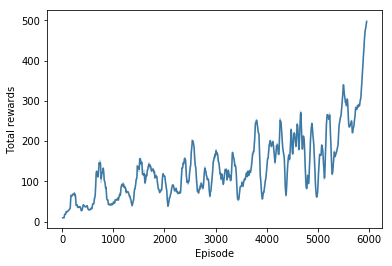

In [116]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

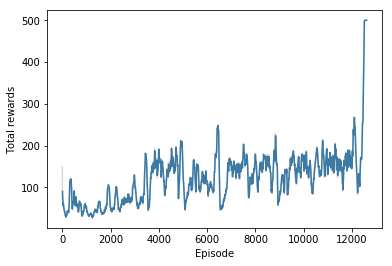

In [98]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

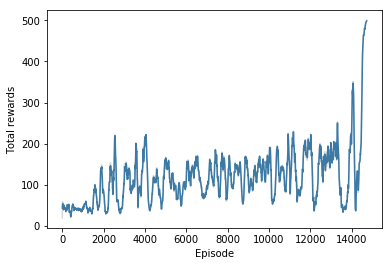

In [70]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

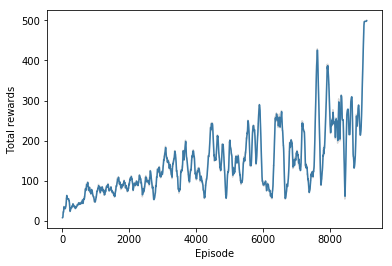

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

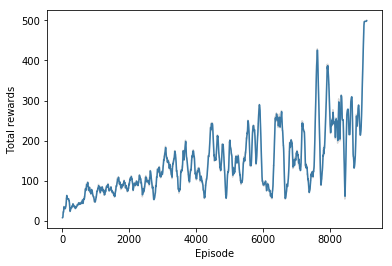

In [27]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

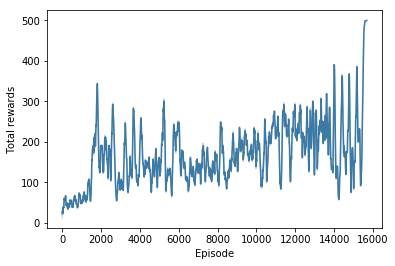

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

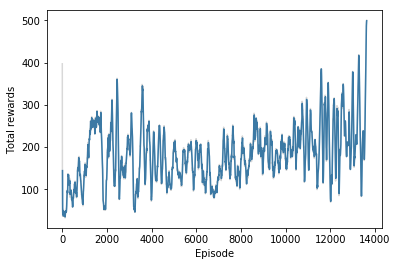

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

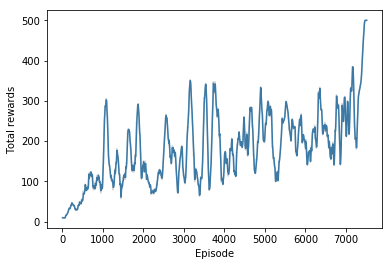

Text(0,0.5,'G losses')

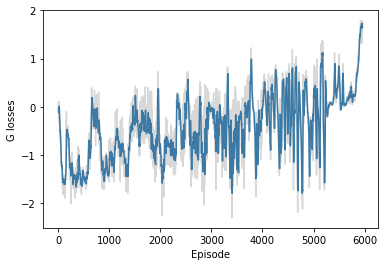

In [117]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

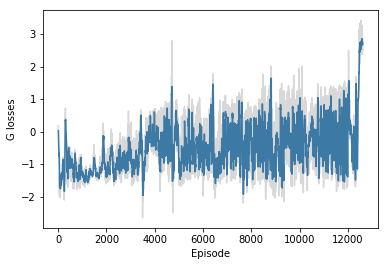

In [99]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

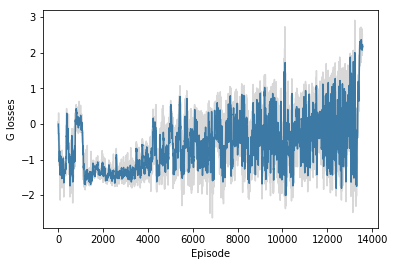

In [83]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

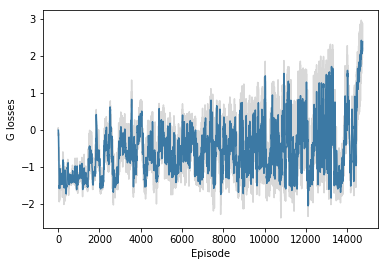

In [71]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

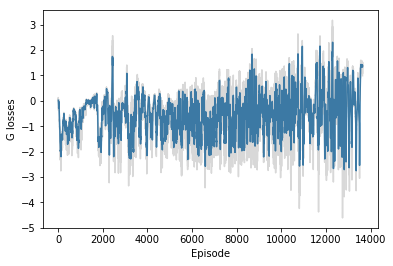

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

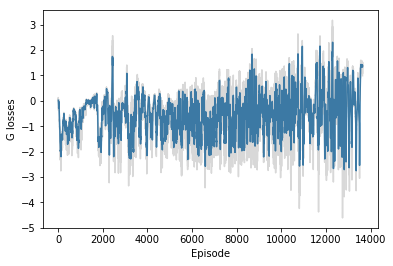

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

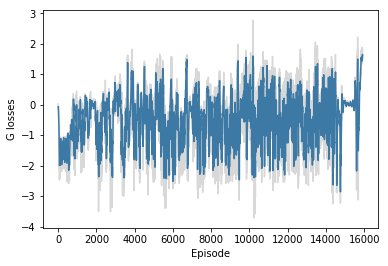
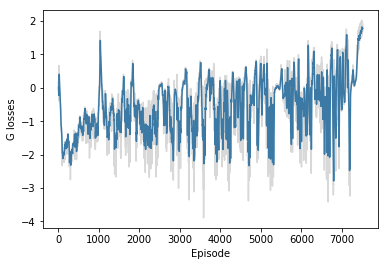

Text(0,0.5,'D losses')

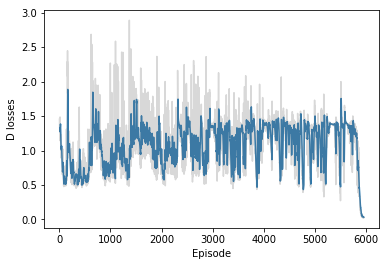

In [118]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

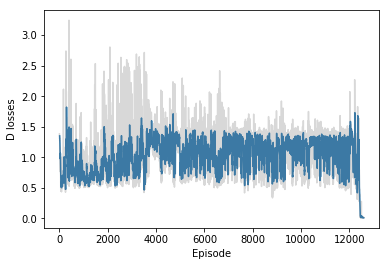

In [100]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

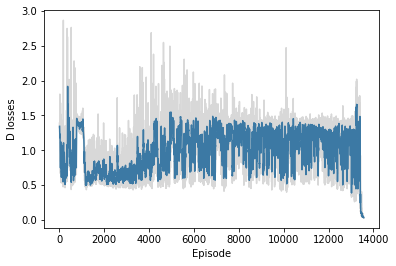

In [84]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

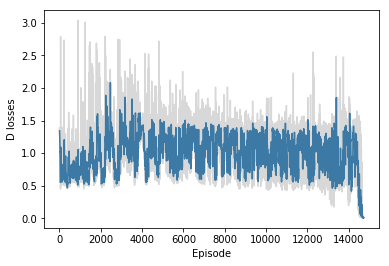

In [72]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

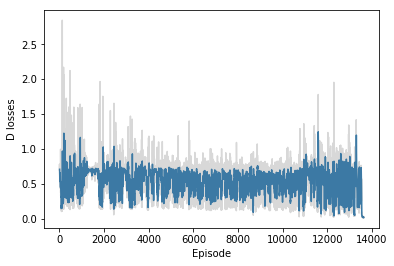

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

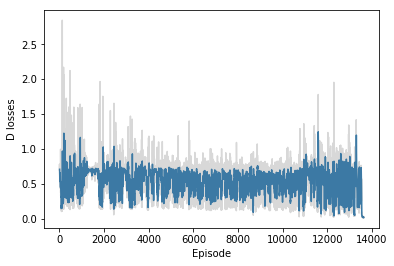

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

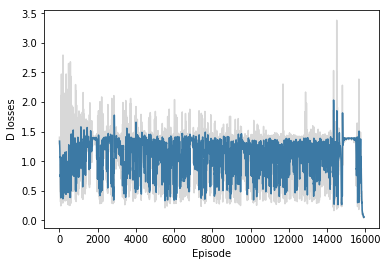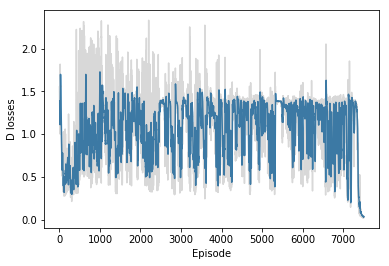

Text(0,0.5,'D losses R')

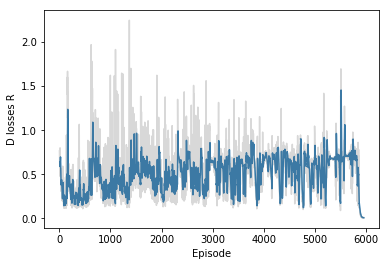

In [119]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

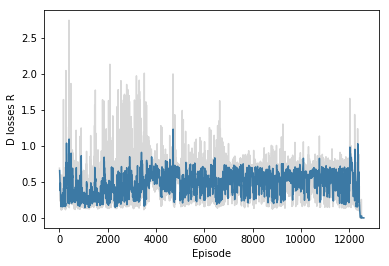

In [101]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

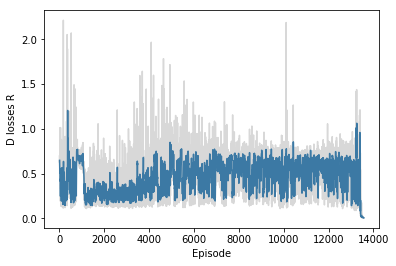

In [85]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

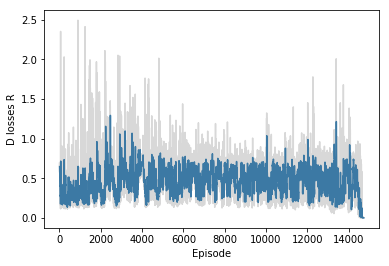

In [73]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

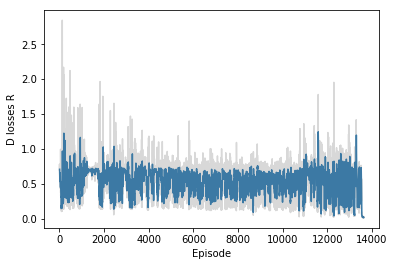

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

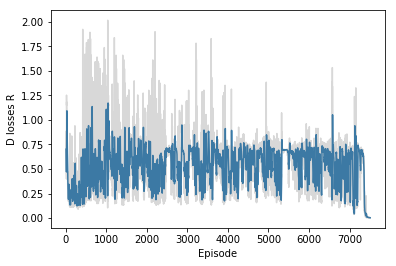

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

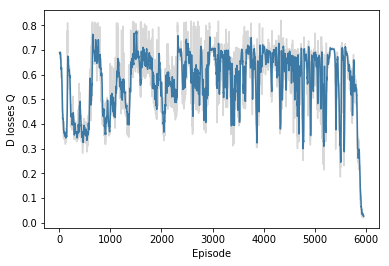

In [120]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

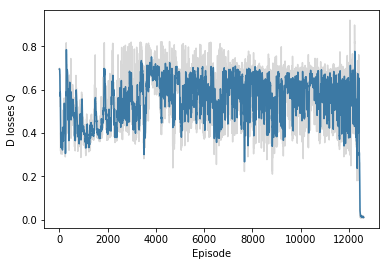

In [102]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

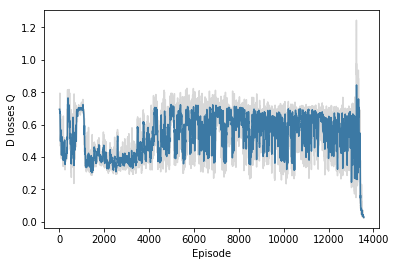

In [86]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

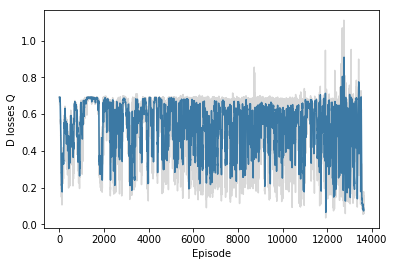

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

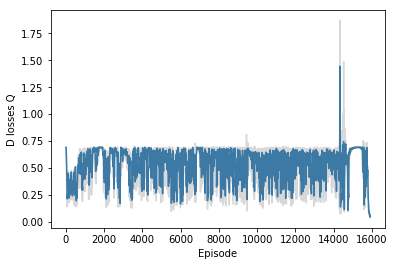

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

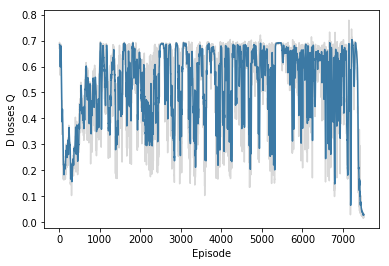

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.